# SBA Loan Default Predicton

## Datasets

There were several changes made by the professor to the dataset from kaggle: columns dropped/added. 

The dataset is from the U.S. Small Business Administration (SBA) The U.S. SBA was founded in 1953 on the principle of promoting and assisting small enterprises in the U.S. credit market (SBA Overview and History, US Small Business Administration (2015)). Small businesses have been a primary source of job creation in the United States; therefore, fostering small business formation and growth has social benefits by creating job opportunities and reducing unemployment. There have been many success stories of start-ups receiving SBA loan guarantees such as FedEx and Apple Computer. However, there have also been stories of small businesses and/or start-ups that have defaulted on their SBA-guaranteed loans.  
More info on the original dataset: https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied


##### Columns:
- `City`: Borrower city
- `State`: Borrower state
- `Zip`: Borrower zip code
- `Bank`: Bank name
- `BankState`: Bank state
- `NAICS`: North American Industry Classification System code
- `NoEmp`: Number of business employees
- `NewExist`: 1 = Existing business, 2 = New business
- `CreateJob`: Number of jobs created
- `RetainedJob`: Number of jobs retained
- `FranchiseCode`: Franchise code, (00000 or 00001) = No franchise
- `UrbanRural`: 1 = Urban, 2 = rural, 0 = undefined
- `RevLineCr`: Revolving line of credit: Y = Yes, N = No
- `LowDoc`: LowDoc Loan Program: Y = Yes, N = No
- `DisbursementGross`: Amount disbursed
- `BalanceGross`: Gross amount outstanding
- `GrAppv`: Gross amount of loan approved by bank
- `SBA_Appv`: SBA’s guaranteed amount of approved loan
- `LoanInd`: Black box feature
- `MIS_Status`: Loan status charged off = CHGOFF, Paid in full =PIF


## Load Data

In [1]:
import pandas as pd
df = pd.read_csv('./data/SBA_loans_project_2.zip')

In [2]:
df.head()

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,...,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd,MIS_Status
0,0,PRINCETON,MN,55371,PEOPLES BANK OF COMMERCE,MN,441120,4,2.0,0,...,1,0,N,N,"$114,577.00",$0.00,"$114,577.00","$85,933.00",1,0
1,1,Kansas city,MO,64116,BANK OF HAYS,KS,481111,14,1.0,0,...,0,1,N,N,"$25,000.00",$0.00,"$25,000.00","$12,500.00",7,0
2,2,BELLWOOD,PA,16617,FIRST COMMONWEALTH BANK,PA,334417,10,1.0,0,...,1,1,0,N,"$85,000.00",$0.00,"$85,000.00","$42,500.00",4,0
3,3,GRAND PRAIRIE,TX,75050,PROSPERITY BANK,TX,0,18,1.0,0,...,1,0,N,N,"$230,000.00",$0.00,"$230,000.00","$195,500.00",5,0
4,4,EL PASO,TX,79925,WESTSTAR BANK,TX,423220,4,1.0,0,...,0,1,N,N,"$32,000.00",$0.00,"$32,000.00","$16,000.00",9,0


In [3]:
(df['MIS_Status'].value_counts()) / len(df) * 100

0    82.438293
1    17.561707
Name: MIS_Status, dtype: float64

In [4]:
len(df)

807450

## Split dataset to Train/Test/Validation

The dataset will be split into train, validation, and test sets in the ratios 0.8, 0.1, and 0.1 respectively.

In [5]:
# Splitting data into train/validation/test sets
from sklearn.model_selection import train_test_split

target_col = 'MIS_Status'

# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(df.drop(target_col, axis=1), df[target_col], random_state=0, test_size=0.1)

# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1, test_size=0.11)

print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

Size of training set: 646767   size of validation set: 79938   size of test set: 80745



# Data Cleaning

### Encode numerical variables that come as strings

Columns `DisbursementGross`, `BalanceGross`, `GrAppv`, `SBA_Appv` are strings styled as '$XXXX.XX'. These will be converted to float values.

In [6]:
# Converting strings for $ amounts to float 
dollar_cols_to_convert = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']

for col in dollar_cols_to_convert:
    X_train[col] = X_train[col].str.replace(',', '').str.replace('$', '', regex=False).astype(float)
    X_valid[col] = X_valid[col].str.replace(',', '').str.replace('$', '', regex=False).astype(float)
    X_test[col] = X_test[col].str.replace(',', '').str.replace('$', '', regex=False).astype(float)

### Convert certain numerical columns to object

Columns `Zip`, `NAICS`, `NewExist`, `FranchiseCode`, `UrbanRural` are of numerical type, but should be categorical because their values represent categories rather than quantities. These will be converted to type 'string'

In [7]:
# List of columns to be converted to object 
num_to_cat_cols = ['Zip', 'NAICS', 'NewExist', 'FranchiseCode', 'UrbanRural']

# Converting to object
X_train[num_to_cat_cols] = X_train[num_to_cat_cols].astype(str)
X_valid[num_to_cat_cols] = X_valid[num_to_cat_cols].astype(str)
X_test[num_to_cat_cols] = X_test[num_to_cat_cols].astype(str)

`LoanInd` is numerical but there is no background information available about this feature so it is unclear whether it should be categorical or numerical. We will create a categorical version of this column called `LoanIndCat`. Default models will be run first with numerical `LoanInd` feature, then with the categorical `LoanIndCat` feature. The model with highest performance should indicate which datatype should be used and the list of predictors to train on will be updated accordingly.

In [8]:
# Creating categorical version of LoanInd feature
X_train['LoanIndCat'] = X_train['LoanInd'].astype(str)
X_valid['LoanIndCat'] = X_valid['LoanInd'].astype(str)
X_test['LoanIndCat'] = X_test['LoanInd'].astype(str)

### Replace certain feature values that appear incorrect

Acceptable values of 'RevLineCr' should be either 'Y' (yes) or 'N' (no). There are many '0' values that we assume should be 'N' and many 'T' values that we assume stands for 'true' and should therefore be converted to 'Y'. There are a few '1' values that will also be converted to 'Y', and some 'R' values that are assumed to indicate 'revolving line of credit', and should be converted to 'Y'. The remaining values are unexpected and will simply be converted to 'Missing'. Imputing them would serve no purpose since they constitute such a small proportion of the data.

In [9]:
# Viewing level counts for RevLineCr column
X_train['RevLineCr'].value_counts()

N    302311
0    185850
Y    144342
T     10939
1        15
R        12
`         8
2         5
,         1
C         1
3         1
4         1
A         1
5         1
-         1
.         1
7         1
Name: RevLineCr, dtype: int64

In [10]:
# Viewing level counts for RevLineCr column
X_valid['RevLineCr'].value_counts()

N    37263
0    22759
Y    18087
T     1415
`        2
1        1
R        1
Q        1
Name: RevLineCr, dtype: int64

In [11]:
# Viewing level counts for RevLineCr column
X_test['RevLineCr'].value_counts()

N    37998
0    23028
Y    17945
T     1366
1        3
Name: RevLineCr, dtype: int64

In [12]:
# Converting certain values of RevLineCr to their assumed correct value 'Y' or 'N'
X_train['RevLineCr'] = X_train['RevLineCr'].replace({'F':'N', 'R':'Y', '1':'Y', 'T':'Y', '0':'N'})
X_valid['RevLineCr'] = X_valid['RevLineCr'].replace({'F':'N', 'R':'Y', '1':'Y', 'T':'Y', '0':'N'})
X_test['RevLineCr'] = X_test['RevLineCr'].replace({'F':'N', 'R':'Y', '1':'Y', 'T':'Y', '0':'N'})

# Replacing remaining values of RevLineCr that are not 'Y' or 'N' with 'Missing'
X_train.loc[~X_train['RevLineCr'].isin(['Y', 'N']), 'RevLineCr'] = 'Missing'
X_valid.loc[~X_valid['RevLineCr'].isin(['Y', 'N']), 'RevLineCr'] = 'Missing'
X_test.loc[~X_test['RevLineCr'].isin(['Y', 'N']), 'RevLineCr'] = 'Missing'

In [13]:
# Confirming RevLineCr values were cleaned up correctly
X_train['RevLineCr'].value_counts()

N          488161
Y          155308
Missing      3298
Name: RevLineCr, dtype: int64

In [14]:
# Confirming RevLineCr values were cleaned up correctly
X_valid['RevLineCr'].value_counts()

N          60022
Y          19504
Missing      412
Name: RevLineCr, dtype: int64

In [15]:
# Confirming RevLineCr values were cleaned up correctly
X_test['RevLineCr'].value_counts()

N          61026
Y          19314
Missing      405
Name: RevLineCr, dtype: int64

Similarly, the 'LowDoc' column contains some values that are neither 'Y' nor 'N'. We will assume that '0' means 'N' and '1' means 'Y' and convert accordingly. This particular set of observations has no instances of 'T' (assumed meaning = true i.e. 'Y') or 'F' (assumed meaning = false i.e. 'N'), but we will account for such instances as well, in case they do occur in the unseen data.

In [16]:
# Viewing level counts for LowDoc column
X_train['LowDoc'].value_counts()

N    562839
Y     79670
0      1082
C       540
S       417
A       355
R        49
Name: LowDoc, dtype: int64

In [17]:
# Viewing level counts for LowDoc column
X_valid['LowDoc'].value_counts()

N    69620
Y     9759
0      143
C       64
S       61
A       42
R        6
Name: LowDoc, dtype: int64

In [18]:
# Viewing level counts for LowDoc column
X_test['LowDoc'].value_counts()

N    70379
Y     9825
0      108
C       77
S       64
A       47
R       11
1        1
Name: LowDoc, dtype: int64

In [19]:
# Converting certain values of LowDoc to their assumed correct value 'Y' or 'N'
X_train['LowDoc'] = X_train['LowDoc'].replace({'1':'Y', '0':'N', 'T':'Y', 'F':'N'})
X_valid['LowDoc'] = X_valid['LowDoc'].replace({'1':'Y', '0':'N', 'T':'Y', 'F':'N'})
X_test['LowDoc'] = X_test['LowDoc'].replace({'1':'Y', '0':'N', 'T':'Y', 'F':'N'})

# Replacing remaining values of LowDoc that are not 'Y' or 'N' with 'Missing'
X_train.loc[~X_train['LowDoc'].isin(['Y', 'N']), 'LowDoc'] = 'Missing'
X_valid.loc[~X_valid['LowDoc'].isin(['Y', 'N']), 'LowDoc'] = 'Missing'
X_test.loc[~X_test['LowDoc'].isin(['Y', 'N']), 'LowDoc'] = 'Missing'

In [20]:
# Confirming LowDoc values were cleaned up correctly
X_train['LowDoc'].value_counts()

N          563921
Y           79670
Missing      3176
Name: LowDoc, dtype: int64

In [21]:
# Confirming LowDoc values were cleaned up correctly
X_valid['LowDoc'].value_counts()

N          69763
Y           9759
Missing      416
Name: LowDoc, dtype: int64

In [22]:
# Confirming LowDoc values were cleaned up correctly
X_test['LowDoc'].value_counts()

N          70487
Y           9826
Missing      432
Name: LowDoc, dtype: int64

The 'NewExist' column contains few unexpected values for this particular set of observations, therefore, we will only replace values that are not '1' (new business) or '2' (existing business) with 'Missing'.

In [23]:
# Viewing level counts for NewExist column
X_train['NewExist'].value_counts()

1.0    463852
2.0    182079
0.0       744
nan        92
Name: NewExist, dtype: int64

In [24]:
# Viewing level counts for NewExist column
X_valid['NewExist'].value_counts()

1.0    57286
2.0    22533
0.0      100
nan       19
Name: NewExist, dtype: int64

In [25]:
# Viewing level counts for NewExist column
X_test['NewExist'].value_counts()

1.0    57909
2.0    22740
0.0       85
nan       11
Name: NewExist, dtype: int64

In [26]:
# Replacing values of NewExist that are not '1' or '2' with 'Missing'
X_train.loc[~X_train['NewExist'].isin(['1.0','2.0']), 'NewExist'] = 'Missing'
X_valid.loc[~X_valid['NewExist'].isin(['1.0','2.0']), 'NewExist'] = 'Missing'
X_test.loc[~X_test['NewExist'].isin(['1.0','2.0']), 'NewExist'] = 'Missing'


In [27]:
# Confirming NewExist values were cleaned up correctly
X_train['NewExist'].value_counts()

1.0        463852
2.0        182079
Missing       836
Name: NewExist, dtype: int64

In [28]:
# Confirming NewExist values were cleaned up correctly
X_valid['NewExist'].value_counts()

1.0        57286
2.0        22533
Missing      119
Name: NewExist, dtype: int64

In [29]:
# Confirming NewExist values were cleaned up correctly
X_test['NewExist'].value_counts()

1.0        57909
2.0        22740
Missing       96
Name: NewExist, dtype: int64

### Replacing Remaining Missing Values

There are still some missing values in the data. These will be replaced with 'Missing' if categorical or 0 if numerical.

In [30]:
# Viewing counts of NaN values
X_train.isna().sum()

index                   0
City                   20
State                  11
Zip                     0
Bank                 1087
BankState            1091
NAICS                   0
NoEmp                   0
NewExist                0
CreateJob               0
RetainedJob             0
FranchiseCode           0
UrbanRural              0
RevLineCr               0
LowDoc                  0
DisbursementGross       0
BalanceGross            0
GrAppv                  0
SBA_Appv                0
LoanInd                 0
LoanIndCat              0
dtype: int64

In [31]:
# Viewing counts of NaN values
X_valid.isna().sum()

index                  0
City                   2
State                  1
Zip                    0
Bank                 129
BankState            130
NAICS                  0
NoEmp                  0
NewExist               0
CreateJob              0
RetainedJob            0
FranchiseCode          0
UrbanRural             0
RevLineCr              0
LowDoc                 0
DisbursementGross      0
BalanceGross           0
GrAppv                 0
SBA_Appv               0
LoanInd                0
LoanIndCat             0
dtype: int64

In [32]:
# Viewing counts of NaN values
X_test.isna().sum()

index                  0
City                   4
State                  1
Zip                    0
Bank                 131
BankState            132
NAICS                  0
NoEmp                  0
NewExist               0
CreateJob              0
RetainedJob            0
FranchiseCode          0
UrbanRural             0
RevLineCr              0
LowDoc                 0
DisbursementGross      0
BalanceGross           0
GrAppv                 0
SBA_Appv               0
LoanInd                0
LoanIndCat             0
dtype: int64

In [33]:
# Replacing Na/Null values
values_to_fill = {}
for col in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[col].dtype):
        values_to_fill[col] = 0
    else:
        values_to_fill[col] = 'Missing'
        
X_train.fillna(value=values_to_fill,inplace=True)
X_test.fillna(value=values_to_fill,inplace=True)
X_valid.fillna(value=values_to_fill,inplace=True)

In [34]:
# Viewing counts of NaN values
X_train.isna().sum()

index                0
City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementGross    0
BalanceGross         0
GrAppv               0
SBA_Appv             0
LoanInd              0
LoanIndCat           0
dtype: int64

In [35]:
# Viewing counts of NaN values
X_valid.isna().sum()

index                0
City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementGross    0
BalanceGross         0
GrAppv               0
SBA_Appv             0
LoanInd              0
LoanIndCat           0
dtype: int64

In [36]:
# Viewing counts of NaN values
X_test.isna().sum()

index                0
City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementGross    0
BalanceGross         0
GrAppv               0
SBA_Appv             0
LoanInd              0
LoanIndCat           0
dtype: int64

#### Creating lists of original numerical columns and original categorical columns for later use

Before moving forward, we will create lists of the original numerical column names and the original categorical column names. These may be useful later on.

In [37]:
# Creating lists of original columns
original_num_cols = []
original_cat_cols = []

for col in X_train.drop(columns=['index']).columns:
    if X_train[col].dtype != 'object':
        original_num_cols += [col]
    else:
        original_cat_cols += [col]

print('Original numerical columns:', original_num_cols, '\n') 
print('Original categorical columns:', original_cat_cols)

Original numerical columns: ['NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv', 'LoanInd'] 

Original categorical columns: ['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'NewExist', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'LoanIndCat']


# Feature Engineering

According to the dataset description on Kaggle, the first two digits of the NAICS code represent the business's sector. A new feature will be created by binning the NAICS values based on the first two digits. In order to acheive this, a dictionary will be created to map the first two digits of the NAICS code to the corresponding sector. This dictionary will be able to handle digits not present in the dictionary. If the first two digits of any NAICS code are not in the dictionary, the NAICS sector will be categorized as 'Missing'.

In [39]:
# Creating a NAICS codes dictionary for later use binning NAICS feature
NAICS_dict = {'11':'Agriculture, forestry, fishing and hunting', 
              '21':'Mining, quarrying, and oil and gas extraction', 
              '22':'Utilities', 
              '23':'Construction', 
              '31':'Manufacturing', 
              '32':'Manufacturing', 
              '33':'Manufacturing', 
              '42':'Wholesale trade', 
              '44':'Retail trade', 
              '45':'Retail trade', 
              '48':'Transportation and warehousing', 
              '49':'Transportation and warehousing', 
              '51':'Information', 
              '52':'Finance and insurance', 
              '53':'Real estate and rental and leasing', 
              '54':'Professional, scientific, and technical services', 
              '55':'Management of companies and enterprises', 
              '56':'Administrative and support and waste management and remediation services', 
              '61':'Educational services', 
              '62':'Health care and social assistance', 
              '71':'Arts, entertainment, and recreation', 
              '72':'Accommodation and food services', 
              '81':'Other services (except public administration)', 
              '92':'Public administration'}

# Creating a custom dictionary sub-class that maps 'Missing' to keys not present in dictionary 
class CustomDict(dict):
    def __missing__(self, key):
        return 'Missing'

# Converting NAICS_dict to custom class defined above
NAICS_dict = CustomDict(NAICS_dict)

Twelve new features will be engineered by transforming the existing features or extracting information using mathematical relationships between the existing features. Descriptions of each new feature are included in the code comments below.

In [40]:
# Feature Engineering
import numpy as np

datasets = [X_train, X_valid, X_test]

for dat in datasets:
    # New feature: log transformation of DisbursementGross
    dat['LogDisbursementGross'] = dat['DisbursementGross'].apply(np.log)
    
    # New feature: log transformation of GrAppv
    dat['LogGrAppv'] = dat['GrAppv'].apply(np.log)
    
    # New feature: log transformation of SBA_Appv
    dat['LogSBA_Appv'] = dat['SBA_Appv'].apply(np.log)
    
    # New feature: binning NAICS into categories based on first two digits of NAICS code (indicating sector)
    dat['NAICS_Sector'] = dat['NAICS'].str[:2]
    dat['NAICS_Sector'] = dat['NAICS_Sector'].map(NAICS_dict)
    
    # New feature: ratio of DisbursementGross to GrAppv
    dat['DisbGrAppvRatio'] = dat['DisbursementGross']/dat['GrAppv']
    
    # New feature: 1 if there is a difference between DisbursementGross and GrAppv, 0 otherwise
    dat['GrantDisbDifferent'] = np.where(dat['DisbursementGross']/dat['GrAppv'] == 1, 0, 1)
    
    #New feature: ratio of SBA_Appv to GrAppv
    dat['SBAGrantRatio'] = dat['SBA_Appv']/dat['GrAppv']
    
    # New feature: 1 if there is a difference between SBAAppv and GrAppv, 0 otherwise
    dat['GrantSBADifferent'] = np.where(dat['SBA_Appv']/dat['GrAppv'] == 1, 0, 1)
    
    # New feature: making CreateJob 0/1 binary 0=no job created, 1=at least 1 job created
    dat['CreateAnyJob'] = np.where(dat['CreateJob']>0, 1, 0)
    
    # New feature:  AnyEmp; 0 if NoEmp=0, 1 if NoEmp>0
    dat['AnyEmp'] = np.where(dat['NoEmp']>0, 1, 0)
    
    # New feature:  AnyRetainedJob 0/1; 0 if RetainedJob=0, 1 if RetainedJob>=1
    dat['AnyRetainedJob'] = np.where(dat['RetainedJob']>0, 1, 0)
    
    #New feature: SBA_Appv^2
    dat['SBA_Appv^2']=dat['SBA_Appv']**2

# Creating list of engineered features
eng_columns = ['LogDisbursementGross', 
               'LogGrAppv', 
               'LogSBA_Appv',
               'NAICS_Sector',
               'DisbGrAppvRatio',
               'SBAGrantRatio',
               'GrantDisbDifferent',
               'CreateAnyJob',
               'AnyEmp',
               'AnyRetainedJob',
               'GrantSBADifferent',
               'SBA_Appv^2']  

# list of binary columns (to drop when scaling numerical features for sklearn model)
binary_columns = ['GrantDisbDifferent', 'GrantSBADifferent', 'CreateAnyJob', 'AnyEmp', 'AnyRetainedJob']

Since we created some new numerical columns, a new list containing both the original numerical columns and the newly engineered ones will be created. This will be useful later on.

In [41]:
# Updating list of numerical columns
numerical_cols = original_num_cols

for col in eng_columns:
    if col not in binary_columns and X_train[col].dtype != 'object':
        numerical_cols += [col]
numerical_cols

['NoEmp',
 'CreateJob',
 'RetainedJob',
 'DisbursementGross',
 'BalanceGross',
 'GrAppv',
 'SBA_Appv',
 'LoanInd',
 'LogDisbursementGross',
 'LogGrAppv',
 'LogSBA_Appv',
 'DisbGrAppvRatio',
 'SBAGrantRatio',
 'SBA_Appv^2']

# Create H2O frames to be used with GBM model 

H2O GBM does automatic one-hot-encoding. Therefore, before one-hot encoding the pandas dataframes to be used with the LightGBM model we will make copies of the pandas dataframes as H2O frames. The H2O frames will be named train_h2o, valid_h2o, and test_h2o and will contain both the predictors and the target variable.

In [42]:
import h2o
h2o.init(nthreads=-1, strict_version_check=True)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 19.0.2+7-44, mixed mode, sharing)
  Starting server from C:\Users\zoepe\OneDrive\Desktop\Spring2023\BUAN 6341\Python\ml-spring-2023\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\zoepe\AppData\Local\Temp\tmp68wwuvqf
  JVM stdout: C:\Users\zoepe\AppData\Local\Temp\tmp68wwuvqf\h2o_zoepe_started_from_python.out
  JVM stderr: C:\Users\zoepe\AppData\Local\Temp\tmp68wwuvqf\h2o_zoepe_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_zoepe_0irith
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.908 Gb
H2O_cluster_total_cores:,20
H2O_cluster_allowed_cores:,20
H2O_cluster_status:,"locked, healthy"


In [43]:
# Convert dataframes to H2O frames

# Adding target column to X sets to prepare for conversion to H2OFrames
y_train_frame = pd.DataFrame({'MIS_Status': y_train}, index=y_train.index)
train = pd.concat([X_train, y_train_frame], axis=1)

y_valid_frame = pd.DataFrame({'MIS_Status': y_valid}, index=y_valid.index)
valid = pd.concat([X_valid, y_valid_frame], axis=1)

y_test_frame = pd.DataFrame({'MIS_Status': y_test}, index=y_test.index)
test = pd.concat([X_test, y_test_frame], axis=1)

# Converting pandas dataframes to H2OFrames
train_h2o = h2o.H2OFrame(train)
valid_h2o = h2o.H2OFrame(valid)
test_h2o = h2o.H2OFrame(test)

# Converting target 0/1 column to factor
train_h2o['MIS_Status'] = train_h2o['MIS_Status'].asfactor()
valid_h2o['MIS_Status'] = valid_h2o['MIS_Status'].asfactor()
test_h2o['MIS_Status'] = test_h2o['MIS_Status'].asfactor()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


After converting to H2O frames, some of the categorical data was automatically converted to numerical because it contains numerical values. Since these features should be categorical, they will be converted to type enum.

In [44]:
# Viewing datatypes after h2o conversion
train_h2o.types

{'index': 'int',
 'City': 'enum',
 'State': 'enum',
 'Zip': 'int',
 'Bank': 'enum',
 'BankState': 'enum',
 'NAICS': 'int',
 'NoEmp': 'int',
 'NewExist': 'int',
 'CreateJob': 'int',
 'RetainedJob': 'int',
 'FranchiseCode': 'int',
 'UrbanRural': 'int',
 'RevLineCr': 'enum',
 'LowDoc': 'enum',
 'DisbursementGross': 'int',
 'BalanceGross': 'int',
 'GrAppv': 'int',
 'SBA_Appv': 'int',
 'LoanInd': 'int',
 'LoanIndCat': 'int',
 'LogDisbursementGross': 'real',
 'LogGrAppv': 'real',
 'LogSBA_Appv': 'real',
 'NAICS_Sector': 'enum',
 'DisbGrAppvRatio': 'real',
 'GrantDisbDifferent': 'int',
 'SBAGrantRatio': 'real',
 'GrantSBADifferent': 'int',
 'CreateAnyJob': 'int',
 'AnyEmp': 'int',
 'AnyRetainedJob': 'int',
 'SBA_Appv^2': 'int',
 'MIS_Status': 'enum'}

The following loop will convert all variables in the H2O frames that are of 'object' type in the pandas dataframes to enum. Additionally, the binary 0/1 features that were engineered and placed in the `binary_columns` list will also be converted to enum since they should be interpreted as categorical. The newly updated datatypes are shown in the output below.

In [45]:
# Converting H2O categorical values to enum
for col in X_train.columns.tolist():
    if col in train_h2o.columns:
        if X_train[col].dtype == 'object' or col in binary_columns:
            train_h2o[col] = train_h2o[col].asfactor()
            valid_h2o[col] = valid_h2o[col].asfactor()
            test_h2o[col] = test_h2o[col].asfactor()

train_h2o.types

{'index': 'int',
 'City': 'enum',
 'State': 'enum',
 'Zip': 'enum',
 'Bank': 'enum',
 'BankState': 'enum',
 'NAICS': 'enum',
 'NoEmp': 'int',
 'NewExist': 'enum',
 'CreateJob': 'int',
 'RetainedJob': 'int',
 'FranchiseCode': 'enum',
 'UrbanRural': 'enum',
 'RevLineCr': 'enum',
 'LowDoc': 'enum',
 'DisbursementGross': 'int',
 'BalanceGross': 'int',
 'GrAppv': 'int',
 'SBA_Appv': 'int',
 'LoanInd': 'int',
 'LoanIndCat': 'enum',
 'LogDisbursementGross': 'real',
 'LogGrAppv': 'real',
 'LogSBA_Appv': 'real',
 'NAICS_Sector': 'enum',
 'DisbGrAppvRatio': 'real',
 'GrantDisbDifferent': 'enum',
 'SBAGrantRatio': 'real',
 'GrantSBADifferent': 'enum',
 'CreateAnyJob': 'enum',
 'AnyEmp': 'enum',
 'AnyRetainedJob': 'enum',
 'SBA_Appv^2': 'int',
 'MIS_Status': 'enum'}

# Encode categorical variables

### H20 Target Encoding

The categorical features with more than 10 levels will be target encoded. We will use H2O target encoder to encode the H2O frames that we will use with the H2O GBM model. The pandas dataframes will also be target encoded later using sklearn target encoder.

In [46]:
from h2o.estimators import H2OTargetEncoderEstimator
from copy import deepcopy

h2o_cat_encoders={}

# Creating list of columns to target encode
h2o_cols_to_te = []

for col in train_h2o.columns:
    if train_h2o[col].types[col] == 'enum':
        if train_h2o[col].nlevels()[0] >= 10:
            h2o_cols_to_te += [col] 

# Defining response variable
response = 'MIS_Status'

# Defining TE model
H2O_te = H2OTargetEncoderEstimator(blending=True,
                                    inflection_point=3,
                                    smoothing=10,
                                    noise=0.15,     
                                    seed=1234)
# Training TE
H2O_te.train(x=h2o_cols_to_te,
                 y=response,
                 training_frame=train_h2o)

# Transforming data
train_h2o = H2O_te.transform(frame=train_h2o, as_training=True)
valid_h2o = H2O_te.transform(frame=valid_h2o, noise=0)
test_h2o = H2O_te.transform(frame=test_h2o, noise=0)

# Renaming target encoded columns
for col in h2o_cols_to_te:
    train_h2o = train_h2o.rename(columns = {col+"_te": col + "_trg"})
    valid_h2o = valid_h2o.rename(columns = {col+"_te": col + "_trg"})
    test_h2o = test_h2o.rename(columns = {col+"_te": col + "_trg"})

    
# Creating list of target encoded column names    
h2o_target_encoded_cols = []
for col in h2o_cols_to_te:
    new_name = col+'_trg'
    h2o_target_encoded_cols += [new_name]


targetencoder Model Build progress: |████████████████████████████████████████████| (done) 100%


In [47]:
train_h2o.head()

City_trg,State_trg,Zip_trg,Bank_trg,BankState_trg,NAICS_trg,FranchiseCode_trg,LoanIndCat_trg,NAICS_Sector_trg,City,State,Zip,Bank,BankState,NAICS,FranchiseCode,LoanIndCat,NAICS_Sector,index,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd,LogDisbursementGross,LogGrAppv,LogSBA_Appv,DisbGrAppvRatio,GrantDisbDifferent,SBAGrantRatio,GrantSBADifferent,CreateAnyJob,AnyEmp,AnyRetainedJob,SBA_Appv^2,MIS_Status
0.406996,0.343786,0.376638,0.344524,0.363173,0.19559,0.192848,0.247197,0.173698,PALM CITY,FL,34990,BANK OF AMERICA NATL ASSOC,NC,624410,1,5,Health care and social assistance,300028,8,1,0,0,1,Y,N,25000,0,25000,12500,5,10.1266,10.1266,9.43348,1,0,0.5,1,0,1,0,1.5625e+08,0
0.110498,0.0468649,0.131174,0.0484698,0.00711255,0.0525576,0.0543839,0.105813,0.085702,NORTHFIELD,MN,55057,ASSOCIATED BANK NATL ASSOC,MN,339920,1,3,Manufacturing,388438,3,1,0,0,0,N,N,90300,0,90300,72240,3,11.4109,11.4109,11.1877,1,0,0.8,1,0,1,0,5.21862e+09,0
0.0989256,0.105353,0.0704899,0.0776901,0.0925147,0.185895,0.162478,0.21385,0.23044,MISSOULA,MT,59802,FIRST SECURITY BK OF MISSOULA,MT,541310,1,2,"Professional, scientific, and technical services",621662,13,1,3,10,1,N,N,450000,0,450000,337500,2,13.017,13.017,12.7293,1,0,0.75,1,1,1,1,1.13906e+11,0
0.272302,0.312294,0.289195,0.420397,0.369414,0.384676,0.269414,0.320571,0.348434,DAYTON,OH,45459,JPMORGAN CHASE BANK NATL ASSOC,IL,713990,1,4,"Arts, entertainment, and recreation",484631,1,1,6,6,1,N,N,215400,0,215400,161550,4,12.2803,12.2803,11.9926,1,0,0.75,1,1,1,1,2.60984e+10,0
0.107506,0.0248093,0.0623075,0.0204786,0.0593889,-0.037721,0.00207636,0.0558272,-0.037721,MELROSE PARK,PA,19026,WELLS FARGO BANK NATL ASSOC,SD,0,1,10,Missing,429422,2,1,0,0,0,N,N,200000,0,200000,150000,10,12.2061,12.2061,11.9184,1,0,0.75,1,0,1,0,2.25e+10,0
0.239422,0.168674,0.317648,0.389961,0.357912,0.453848,0.0958314,0.152524,0.206339,SILVER SPRING,MD,20906,CAPITAL ONE NATL ASSOC,VA,236116,1,8,Construction,538740,6,1,0,6,1,N,N,35000,0,35000,17500,8,10.4631,10.4631,9.76996,1,0,0.5,1,0,1,1,3.0625e+08,0
0.0549607,0.0925065,0.0663294,-0.0141515,-0.0136538,0.178124,0.00480864,0.0586492,0.0755182,NASHVILLE,TN,37221,PINNACLE BANK,TN,423310,1,7,Wholesale trade,568055,1,1,2,0,1,Y,N,184809,0,150000,75000,7,12.1271,11.9184,11.2252,1.23206,1,0.5,1,1,1,0,5.625e+09,0
0.518312,0.186907,0.609677,0.0693094,0.047418,0.0456343,0.0854317,0.139272,0.0456343,DEARBORN,MI,48126,"FIRSTMERIT BANK, N.A.",MI,0,1,7,Missing,5487,13,1,0,0,0,N,N,222826,0,250000,187500,7,12.3141,12.4292,12.1415,0.891304,1,0.75,1,0,1,0,3.51562e+10,0
0.100512,0.0521643,0.0589624,-0.078059,-0.0112461,0.00521996,0.0450173,0.0964464,0.00521996,HYANNIS,MA,2061,SOUTH EASTERN ECONOMIC DEVEL C,MA,0,1,3,Missing,584781,5,1,5,0,0,N,N,275000,0,275000,275000,3,12.5245,12.5245,12.5245,1,0,1,0,1,1,0,7.5625e+10,0
0.299247,0.242378,0.236276,0.243982,0.202625,0.210099,0.249897,0.30241,0.210099,CRYSTAL,MN,55429,ASSOCIATED BANK NATL ASSOC,MN,0,1,9,Missing,300435,13,1,0,0,0,N,N,525000,0,525000,393750,9,13.1712,13.1712,12.8835,1,0,0.75,1,0,1,0,1.55039e+11,1


### One-Hot-Encoding of pandas dataframe columns with less than 10 levels

The categorical features with less than 10 levels will be one-hot encoded using the scikit-learn one-hot encoder. The pandas dataframes will be used with the LightGBM model.

In [48]:
#OHE CATEGORICAL ENCODING
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy

# columns to ohe encode
cols_to_ohe=[]
# Columns to drop from ML models
cols_to_drop = []
# Categorical encoders dictionary
cat_encoders = {}
# New categorical (encoded) columns
cat_enc_columns = []


#One-hot-encoding columns with less than 10 levels
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        if X_train[col].nunique() < 10:
            print("One-hot encoding of ", col)
            enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            enc.fit(X_train[[col]])

            # One-hot-encode Train
            result = enc.transform(X_train[[col]])
            ohe_columns = [col+"_"+str(x) for x in enc.categories_[0]]
            cat_enc_columns = cat_enc_columns + ohe_columns 
            result_train = pd.DataFrame(result, columns=ohe_columns, index=X_train.index)
            X_train = pd.concat([X_train, result_train], axis=1)

            # One-hot-encode Valid
            result = enc.transform(X_valid[[col]])
            result_valid = pd.DataFrame(result, columns=ohe_columns, index=X_valid.index)
            X_valid = pd.concat([X_valid, result_valid], axis=1)

            # One-hot-encode Test
            result = enc.transform(X_test[[col]])
            result_test = pd.DataFrame(result, columns=ohe_columns, index=X_test.index)
            X_test = pd.concat([X_test, result_test], axis=1)

            cat_encoders[col] = [deepcopy(enc),"ohe"]  
            cols_to_drop.append(col) 
            cols_to_ohe.append(col)

One-hot encoding of  NewExist
One-hot encoding of  UrbanRural
One-hot encoding of  RevLineCr
One-hot encoding of  LowDoc


### Target Encoding of pandas dataframe categorical features

### sklearn target encoder

The scikit-learn target encoder is used to encode categorical features with more than 10 levels in the pandas dataframes which will be used with the LightGBM model.

In [49]:
import category_encoders as ce

cols_to_target_encode = []

# Creating list of columns to target encode and adding to list of columns to drop
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        if X_train[col].nunique() >= 10:
            cols_to_target_encode.append(col)
            cols_to_drop.append(col)

# Target encoding
target_encoder = ce.TargetEncoder(cols=cols_to_target_encode)
target_encoder.fit(X_train[cols_to_target_encode],y_train)
X_train_target_enc = target_encoder.transform(X_train[cols_to_target_encode])
X_valid_target_enc = target_encoder.transform(X_valid[cols_to_target_encode])
X_test_target_enc = target_encoder.transform(X_test[cols_to_target_encode])

te_columns = []

for col in cols_to_target_encode:
    X_train[col+"_trg"] = X_train_target_enc[col]
    X_valid[col+"_trg"] = X_valid_target_enc[col]
    X_test[col+"_trg"] = X_test_target_enc[col]
    te_columns.append(col+"_trg")
    cat_enc_columns.append(col+"_trg")

cat_encoders[("cols_to_target_encode","te")] = [deepcopy(target_encoder),"te"]

# Train and tune ML models

## GBM (H2O)

The first model we will train is H2O's Gradient Boosting Estimator (GBM).

In [50]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

Below we define the response variable `MIS_Status`, and the list of predictors that will be used for training. The original columns that were target encoded are excluded from the list of predictors since we will use the target encoded versions. The `index` column is also excluded.

In [51]:
# Defining response column and list of predictors to use for training
response = 'MIS_Status'

predictors = train_h2o.columns

# Removing unwanted columns from predictors list
items_to_remove = h2o_cols_to_te + ['index'] + [response]
for item in items_to_remove:
    if item in predictors:
        predictors.remove(item)

The list of predictors initially contains both the categorical and numerical versions of the `LoanInd` feature. However, we will now create two alternative predictor lists, one including the categorical `LoanIndCat_trg` feature but not the numerical one, and one containing the numerical `LoanInd` feature but not the categorical one. The predictor list that results in the best performance on the preliminary model with default parameters will be kept in the list of predictors when we tune the final model.

In [52]:
# creating list of predictors with numerical LoanInd removed
predictors_loancat = [x for x in predictors if x !='LoanInd']

# creating list of predictors with categorical LoanInd removed
predictors_loanum = [x for x in predictors if x !='LoanIndCat_trg']

### Building default GBM models to get baseline performance

First, we will train a GBM model using defaulr parameters and using the predictor list that includes the numerical `LoanInd` feature but not the categorical one.

In [53]:
# With numerical LoanInd
gbm = H2OGradientBoostingEstimator()
gbm.train(x=predictors_loanum, y=response, training_frame=train_h2o)

## Show a detailed model summary
print(gbm)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1683467860233_2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          22833                  5            5            5             28            32            31.68

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.10946484332925291
RMSE: 0.33085471634730085
LogLoss: 0.3546311556727671
Mean Per-Class Error: 0.2695365574738646
AUC: 0.828039374136576
AUCPR: 0.5513809729265695
Gini: 0.656078748273152

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2503810

We obtained a baseline performance of 79.395% AUC using the numerical `LoanInd` feature.

In [54]:
## Get the AUC on the validation set with numerical LoanInd
perf = gbm.model_performance(valid_h2o)
print(perf.auc())

0.793953451602009


Now we will train another GBM model using default parameters and the predictor list including the categorical `LoanIndCat_trg` feature but not the numerical one.

In [55]:
gbm = H2OGradientBoostingEstimator()
gbm.train(x=predictors_loancat, y=response, training_frame=train_h2o)

## Show a detailed model summary
print(gbm)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1683467860233_11


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          22712                  5            5            5             28            32            31.48

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1079427522689966
RMSE: 0.3285464233087869
LogLoss: 0.3496691595135301
Mean Per-Class Error: 0.2607707083367111
AUC: 0.835351737376518
AUCPR: 0.5598924391919017
Gini: 0.670703474753036

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24742854

In [56]:
gbm = H2OGradientBoostingEstimator()
gbm.train(x=predictors_loancat, y=response, training_frame=train_h2o)



gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1683467860233_37


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          22715                  5            5            5             28            32            31.48

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1079427522689966
RMSE: 0.3285464233087869
LogLoss: 0.3496691595135301
Mean Per-Class Error: 0.2607707083367111
AUC: 0.835351737376518
AUCPR: 0.5598924391919017
Gini: 0.670703474753036

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2474285401053241
       0       1       Error    Rate
-----  ------  ------  -------  -------------------
0      455044  78162   0.1466   (78162.0/533206.0)
1      42580   70981   0.375    (42580.0/113561.0)
Total  497624  149143  0.1867   (120742.0/646767.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.247429     0.540388  222
max f2                       0.136084     0.647532  292
max f0point5                 0.394743     0.553469  152
max accuracy                 0.444488     0.852339  132
max precision                0.941142     1         0
max recall                   0.0174459    1         396
max specificity              0.941142     1         0
max absolute_mcc             0.275647     0.432843  207
max min_per_class_accuracy   0.177882     0.753004  263
max mean_per_class_accuracy  0.179444     0.753693  262
max tns                      0.941142     533206    0
max fns                      0.941142     113548    0
max fps                      0.0144061    533206    399
max tps                      0.0174459    113561    396
max tnr                      0.941142     1         0
max fnr                      0.941142     0.999886  0
max fpr                      0.0144061    1         399
max tpr                      0.0174459    1         396

Gains/Lift Table: Avg response rate: 17.56 %, avg score: 17.57 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100005                   0.774325           5.06398    5.06398            0.889147         0.822694   0.889147                    0.822694            0.0506424       0.0506424                  406.398   406.398            0.0492977
2        0.020001                    0.706016           4.54358    4.80378            0.797774         0.738411   0.84346                     0.780552            0.0454381       0.0960805                  354.358   380.378            0.0922827
3        0.03                        0.648223           4.24309    4.6169             0.745013         0.677056   0.810648                    0.746057            0.0424265       0.138507                   324.309   361.69             0.131617
4        0.0400005                   0.597038           3.87349    4.43104            0.680118         0.622064   0.778014                    0.715058            0.0387369       0.177244                   287.349   343.104            0.166473
5        0.050001                    0.555589           3.53184    4.2512             0.62013          0.5

We obtained a baseline performance of 80.056% AUC using the numerical `LoanInd` feature.

In [57]:
## Get the AUC on the validation set
perf = gbm.model_performance(valid_h2o)
print(perf.auc())

0.8005625168633236


The model that used the categorical version of `LoanInd` performed slightly better, therefore we will use the set of predictors that includes categorical `LoanInd` but not the numerical version. The final list of predictors is updated below.

In [58]:
# setting predictors equal to predictor list with numerical version of LoanInd
predictors = predictors_loancat.copy()

Below is a preview of the data that will be used for training:

In [59]:
train_h2o[predictors]

City_trg,State_trg,Zip_trg,Bank_trg,BankState_trg,NAICS_trg,FranchiseCode_trg,LoanIndCat_trg,NAICS_Sector_trg,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LogDisbursementGross,LogGrAppv,LogSBA_Appv,DisbGrAppvRatio,GrantDisbDifferent,SBAGrantRatio,GrantSBADifferent,CreateAnyJob,AnyEmp,AnyRetainedJob,SBA_Appv^2
0.406996,0.343786,0.376638,0.344524,0.363173,0.19559,0.192848,0.247197,0.173698,8,1,0,0,1,Y,N,25000,0,25000,12500,10.1266,10.1266,9.43348,1,0,0.5,1,0,1,0,1.5625e+08
0.110498,0.0468649,0.131174,0.0484698,0.00711255,0.0525576,0.0543839,0.105813,0.085702,3,1,0,0,0,N,N,90300,0,90300,72240,11.4109,11.4109,11.1877,1,0,0.8,1,0,1,0,5.21862e+09
0.0989256,0.105353,0.0704899,0.0776901,0.0925147,0.185895,0.162478,0.21385,0.23044,13,1,3,10,1,N,N,450000,0,450000,337500,13.017,13.017,12.7293,1,0,0.75,1,1,1,1,1.13906e+11
0.272302,0.312294,0.289195,0.420397,0.369414,0.384676,0.269414,0.320571,0.348434,1,1,6,6,1,N,N,215400,0,215400,161550,12.2803,12.2803,11.9926,1,0,0.75,1,1,1,1,2.60984e+10
0.107506,0.0248093,0.0623075,0.0204786,0.0593889,-0.037721,0.00207636,0.0558272,-0.037721,2,1,0,0,0,N,N,200000,0,200000,150000,12.2061,12.2061,11.9184,1,0,0.75,1,0,1,0,2.25e+10
0.239422,0.168674,0.317648,0.389961,0.357912,0.453848,0.0958314,0.152524,0.206339,6,1,0,6,1,N,N,35000,0,35000,17500,10.4631,10.4631,9.76996,1,0,0.5,1,0,1,1,3.0625e+08
0.0549607,0.0925065,0.0663294,-0.0141515,-0.0136538,0.178124,0.00480864,0.0586492,0.0755182,1,1,2,0,1,Y,N,184809,0,150000,75000,12.1271,11.9184,11.2252,1.23206,1,0.5,1,1,1,0,5.625e+09
0.518312,0.186907,0.609677,0.0693094,0.047418,0.0456343,0.0854317,0.139272,0.0456343,13,1,0,0,0,N,N,222826,0,250000,187500,12.3141,12.4292,12.1415,0.891304,1,0.75,1,0,1,0,3.51562e+10
0.100512,0.0521643,0.0589624,-0.078059,-0.0112461,0.00521996,0.0450173,0.0964464,0.00521996,5,1,5,0,0,N,N,275000,0,275000,275000,12.5245,12.5245,12.5245,1,0,1,0,1,1,0,7.5625e+10
0.299247,0.242378,0.236276,0.243982,0.202625,0.210099,0.249897,0.30241,0.210099,13,1,0,0,0,N,N,525000,0,525000,393750,13.1712,13.1712,12.8835,1,0,0.75,1,0,1,0,1.55039e+11


### GBM Hyperparameter Tuning

Now a GBM model will be tuned using a parameter space of 420 combinations. Due to time constraints, not all of the 420 combinations will be iterated through and the grid search will stop once 150 models have been trained, as specified in the search_criteria_tune list. A "RandomDiscrete" search strategy will be used, so even though not all 420 models will be trained, we can ensure that the grid does not only produce models for the parameter values at the beginning of each specified parameter value range, but uses values from the entire range. The performance is scored using the validation set.

The resulting grid, with models listed in order of decreasing AUC performance on the validation set, is shown in the output below.

In [60]:
import math
# create hyperameter and search criteria lists
hyper_params_tune = {'max_depth' : list(range(5,15,2)), #5
                'sample_rate': [x/100. for x in range(20,81,20)], #4
                'col_sample_rate' : [x/100. for x in range(20,66,15)], #3
                'min_rows': [2**x for x in range(3,11,1)], #7
                    }
search_criteria_tune = {'strategy': "RandomDiscrete",  
                   'max_models': 150, 
                   'seed' : 1234,
                   'stopping_rounds' : 5,
                   'stopping_metric' : "AUC",
                   'stopping_tolerance': 1e-4
                   }

In [61]:
gbm_final_grid = H2OGradientBoostingEstimator(ntrees=400,
                                       learn_rate=0.05,
                                       learn_rate_annealing = 0.99,
                                       seed = 1234,
                                       score_tree_interval = 10,
                                       stopping_rounds = 5,
                                       stopping_metric = "AUC",
                                       stopping_tolerance = 1e-4)

#Build grid search with previously made GBM and hyper parameters
final_grid = H2OGridSearch(gbm_final_grid, hyper_params = hyper_params_tune,
                                    grid_id = 'final_grid1',
                                    search_criteria = search_criteria_tune)
#Train grid search
final_grid.train(x=predictors, 
           y=response,
           training_frame = train_h2o,
           validation_frame = valid_h2o)

sorted_final_grid = final_grid.get_grid(sort_by='auc',decreasing=True)
sorted_final_grid

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,max_depth,min_rows,sample_rate,model_ids,auc
,0.35,13.0,8.0,0.8,final_grid1_model_6,0.8129361
,0.2,13.0,32.0,0.6,final_grid1_model_19,0.8129315
,0.65,13.0,8.0,0.6,final_grid1_model_38,0.8128648
,0.5,13.0,128.0,0.8,final_grid1_model_58,0.8127612
,0.35,13.0,16.0,0.8,final_grid1_model_68,0.8127033
,0.5,13.0,32.0,0.6,final_grid1_model_104,0.8125186
,0.2,13.0,64.0,0.6,final_grid1_model_129,0.8125110
,0.35,13.0,16.0,0.4,final_grid1_model_50,0.8124739
,0.5,13.0,128.0,0.6,final_grid1_model_91,0.8124576
,0.5,13.0,64.0,0.4,final_grid1_model_35,0.8122027


### GBM Performance: AUC

The best model has an AUC of 81.369% on the test set, and 81.294% on the validation set. The AUCs are very similar, which means the model is not overfitting.

In [62]:
#Get the best model from the list (the model name listed at the top of the table)
best_gbm = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
performance_best_gbm = best_gbm.model_performance(test_h2o)
print("Best Grid Model AUC on Test:",performance_best_gbm.auc())
print("Best Grid Model AUC on Validation:",best_gbm.model_performance(valid_h2o).auc())

Best Grid Model AUC on Test: 0.8136967212446089
Best Grid Model AUC on Validation: 0.8129360949100081


The parameters for the best model are shown below:

In [63]:
best_gbm.summary()

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,310.0,310.0,7850126.0,13.0,13.0,13.0,804.0,3443.0,2011.9226


### Optimal threshold to maximize F1

Below we will obtain the optimal threshold to maximize the F1 score on the test set.

In [64]:
# Getting Optimal threshold to maximize F1 score
threshold_h2o = best_gbm.model_performance(test_data=test_h2o).F1()[0][0]
print(f'Optimal threshold: {threshold_h2o}')

Optimal threshold: 0.24370268135143283


### GBM Performance: Confusion Matrix

Using the threshold found above we will obtain the confusion matrix on the test set.

In [65]:
# Confusion matrix for test dataset
best_gbm.model_performance(test_h2o).confusion_matrix(thresholds = threshold_h2o)

,0,1,Error,Rate
0,55936.0,10629.0,0.1597,(10629.0/66565.0)
1,5664.0,8516.0,0.3994,(5664.0/14180.0)
Total,61600.0,19145.0,0.2018,(16293.0/80745.0)


### GBM Model Interpretation

The GBM model will be interpreted using a variety of different methods including an analysis of global and permutation feature importances, an analysis of summary shapley values, and finally an examination of individual records' shapley values to determine how each feature contributes to the model prediction.

#### Global Feature Importance

The below plot displays the global feature importances for the GBM model. It appears that the top 5 most important features in order of decreasing importance are `Bank`, followed by `FranchiseCode` and `Zip` which have very similar feature importances, followed by `LoanIndCat` and `NAICS`. The feature importances seem to degrade fairly gradually as we go down the list of features on the y-axis. The five least important features in order starting  from the least important are `BalanceGross`, `AnyEmp`, `LowDoc`, `SBA_Appv^2` and `CreateJob`. 

However, the default feature importance may not be reliable because the importances are calculated based on the number of times a feature causes a split on a tree in our model. Features with a higher number of levels tend to split more often, but this does not always correlate directly with actual importance. To obtain a less biased summary of the feature importances we will analyze the permutation feature importances next.

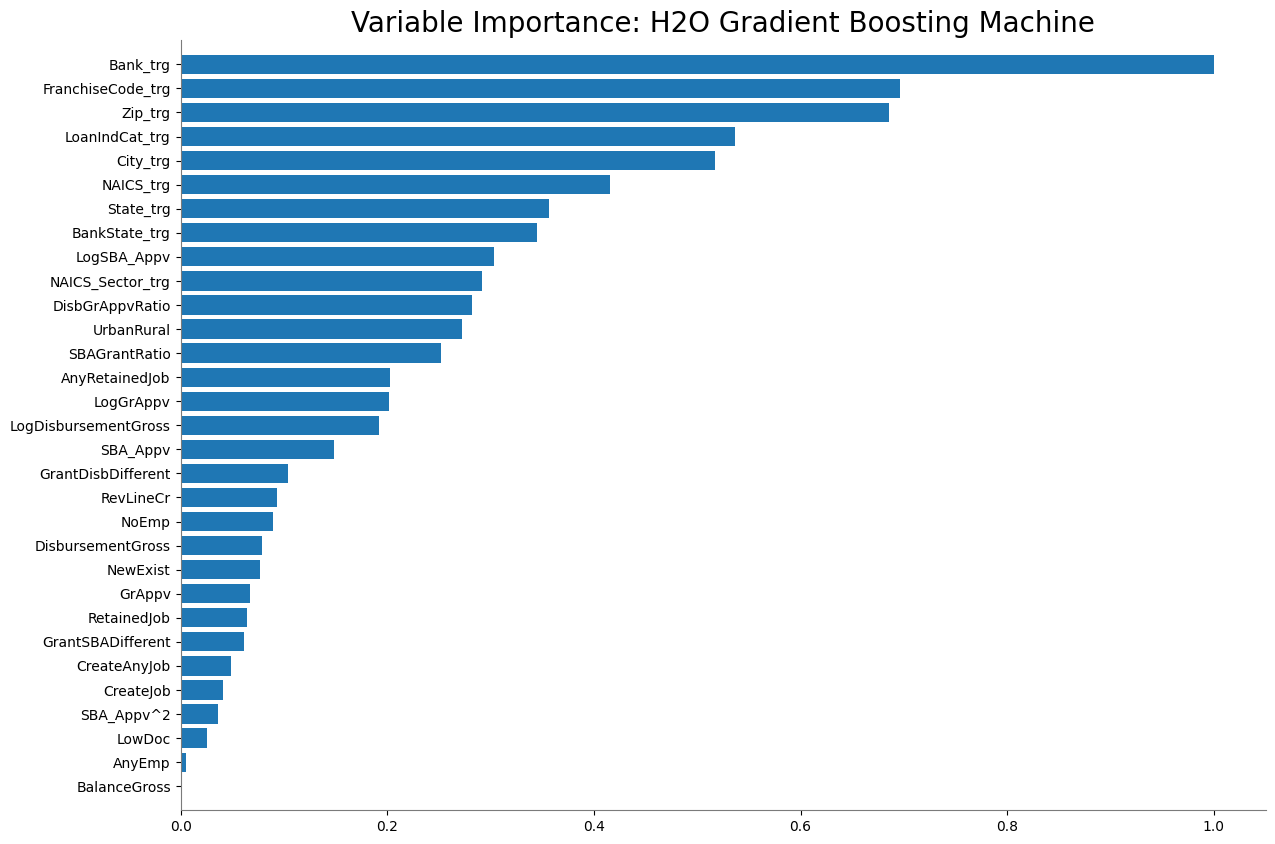

<Figure size 640x480 with 0 Axes>

In [66]:
best_gbm.varimp_plot(num_of_features=31)

#### Permutation Feature Importance

A bar plot illustrating the permutation feature importance is shown below. The permutiation feature importance for each feature is calculated based on the change in prediction error after permuting that feature's values. Unimportant features will show a minimal decrease in the prediction errors when their values are permuted. This method is more reliable because the importance is now correlated with predictive power of the feature.

`Bank` is still the most important feature by a sizeable margin, and again it is followed by `FranchiseCode` and `Zip`. Next we see `UrbanRural` and then `NAICS`. The least important features are `BalanceGross`, `SBA_Appv^2`, `RetainedJob`, `AnyEmp`, and `CreateJob`.  

However, thre are also some clear differences between the permutiation feature importances and the default ones. `FranchiseCode` is now considerably more important than than `Zip`, whereas in the default feature importance plot their importances were very close.  Using permutation feature importance `UrbanRural` is the fourth most important feature whereas by the default feature importance calculation it was the twelvth. After the top six features, the remaining permutation feature importances are much smaller and degrade much more abruptly going down the feature list than they did on the default feature importance plot.

It makes sense that `Bank` is the most important feature because we expect that different banks have different policies that may be more strict or less strict and this will clearly have an effect on the incidence of loan default at each bank. `FranchiseCode` is also expected to be important because the type of franchise is a good indicator of whether that business is successful which has a direct effect on the probability of defaulting on their loan. Similarly, `Zip` and `UrbanRural` are important for similar reasons. They indicate the specific location of the small business and the urban (or non urban) environment, both of which are expected to have a strong correlation with business success and in turn, loan default. `NAICS` is important because it indicates what industry the small business is in and since in certain industries starting a small business is more risky than in others, this is expected to correlate with how well the business does and whether it will be able to pay back their loan.

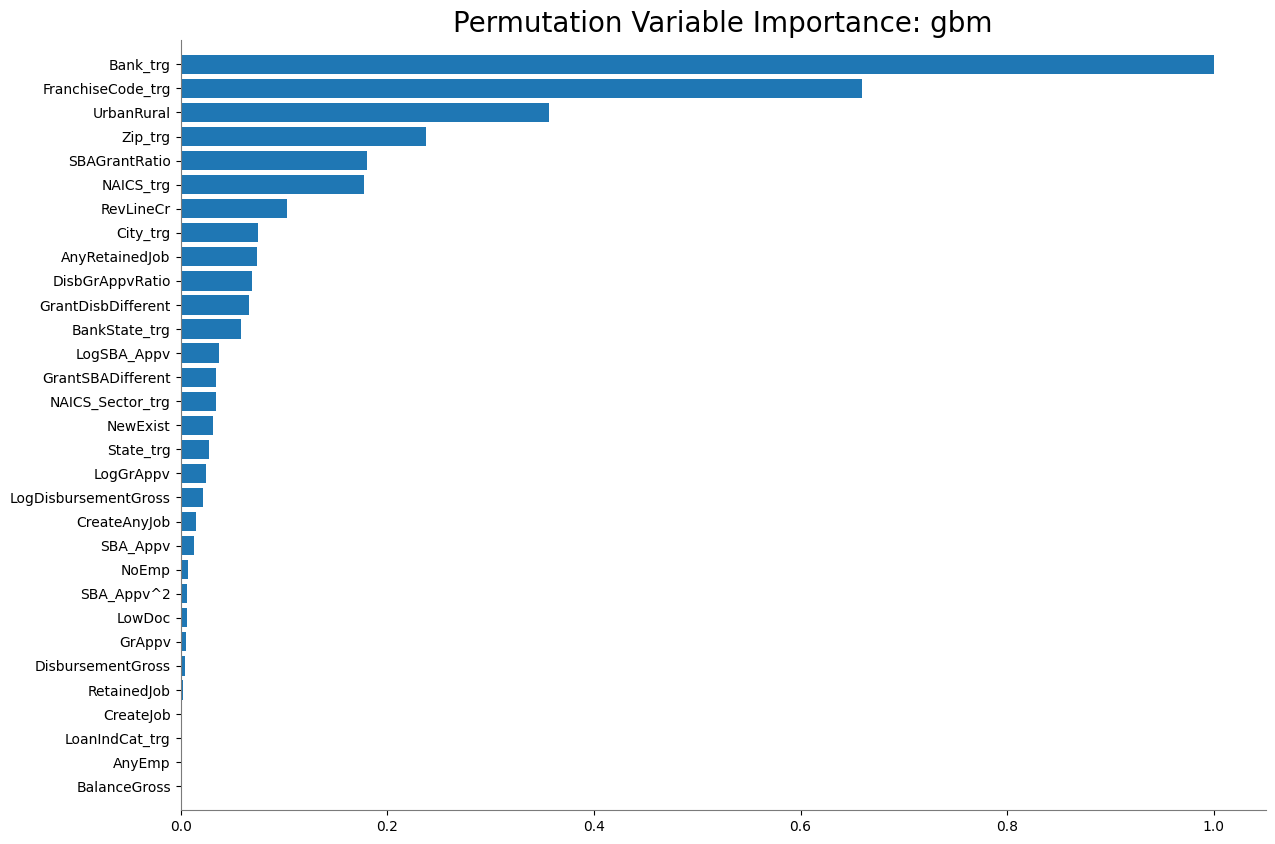

Variable,Relative Importance,Scaled Importance,Percentage
Bank_trg,0.0802985,1.0,0.3001820
FranchiseCode_trg,0.0529192,0.6590314,0.1978293
UrbanRural,0.0286601,0.3569198,0.1071409
Zip_trg,0.0190537,0.2372858,0.0712289
SBAGrantRatio,0.0144811,0.1803408,0.0541351
NAICS_trg,0.0142646,0.1776444,0.0533256
RevLineCr,0.0082926,0.1032722,0.0310004
City_trg,0.0060103,0.0748494,0.0224684
AnyRetainedJob,0.0059353,0.0739151,0.0221880
DisbGrAppvRatio,0.0055735,0.0694101,0.0208357


In [67]:
# plot permutation importance (bar plot)
best_gbm.permutation_importance_plot(test_h2o, num_of_features=31)

#### Shapley Summary Plot

Below is the summary plot of shapley values for the test set. Only 10,000 records are sampled from the test data to avoid overplotting and to produce the plot in a reasonable amount of time. Only the top 20 features are plotted.

This plot provides even more information than the permutation feature importance plot because beyond feature importance, it also displays whether the contribution of each feature impacts the prediction positively or negatively depending on that feature's value.

`Bank`, `Zip`, `UrbanRural`, `FranchiseCode`, and `GrantDisbRatio` are the most important features.These results agree with the permutation feature importance plot.

It can be observed that smaller values of the target encoded variables generally have negative shapley values meaning that they usually negatively impact the prediction of the probability of default, and higher values of the target encoded variables will usually positively impact the model prediction. This makes sense because the target encoded values that have more zeros than ones in the target variable have lower target encoded values and vice versa. We see this pattern for almost all the target encoded features on the plot except for `State`, `NAICS_Sector` and `LoanInd`. `State` and `NAICS_Sector`show the opposite pattern: lower target encoded values tend to have positive shapley values and higher target encoded values tend to have negative shapley values. This indicates that the model has difficulty predicting loan default based on these values. For this reason it makes sense that `State` and `NAICS_Sector` are listed near the bottom of the plot indicating they are not as important as the other target encoded variables, all of which are near the top. 

Interestingly, `LoanIndCat`, which was also target encoded, has an even mix of positive and negative shapley values across all that feature's levels. Despite this, the feature is still seventh on the list in order of importance.

The `SBAGrantRatio` feature is fifth on the list and appears to contribute more negatively to the prediction of loan default when the ratio between the guaranteed loan amount by the SBA and the approved loan amount by the bank is higher. This makes sense because in cases where the SBA provided a larger portion of the loan, the small business were left to pay just a small remainder of it back to the bank, which we expect would decrease the probability of default.


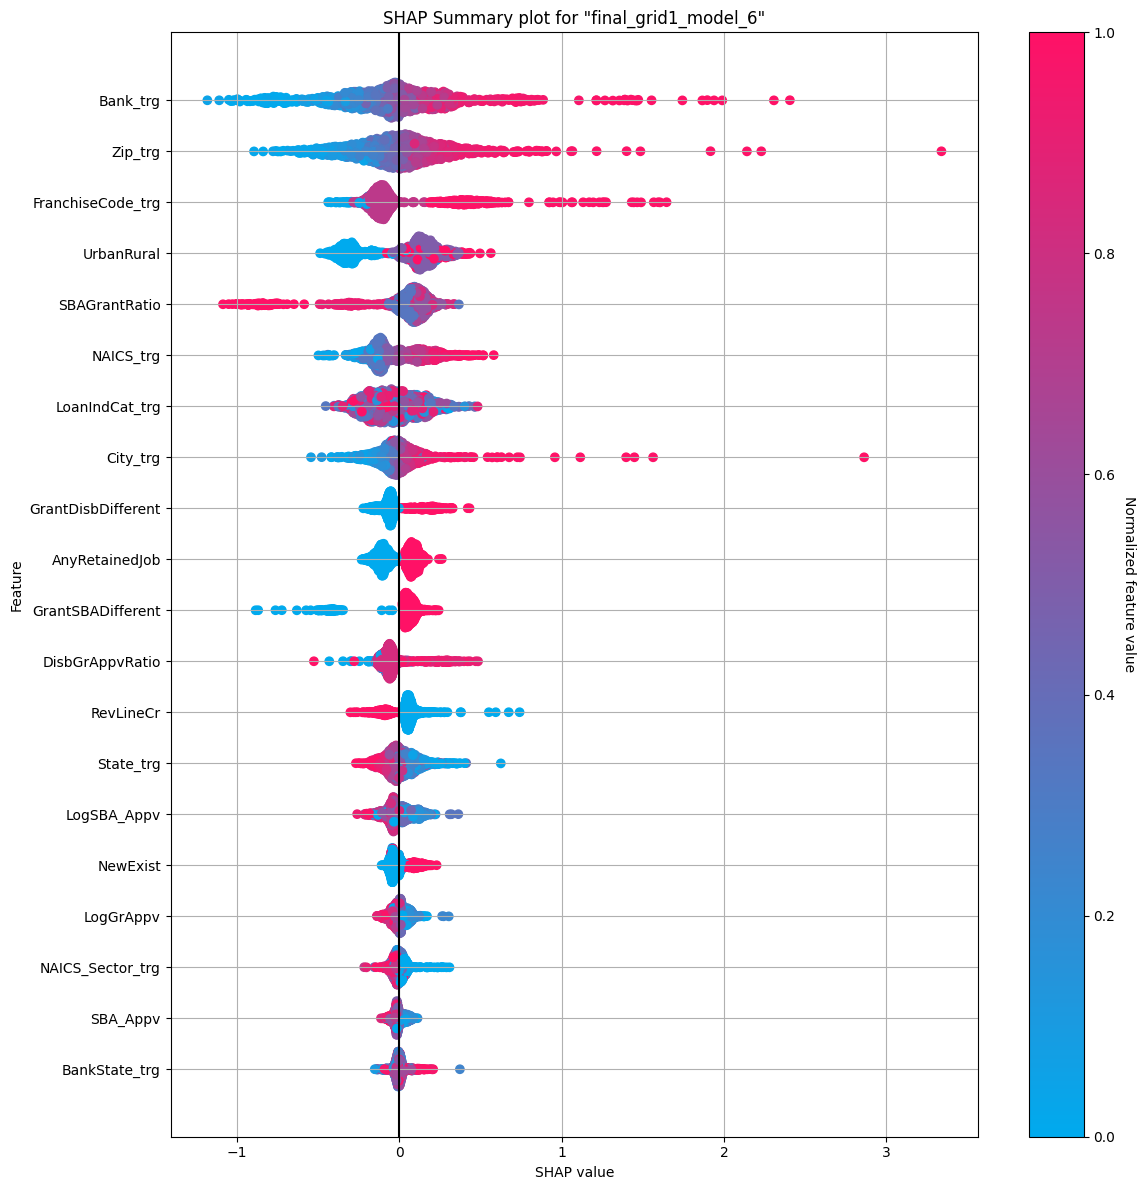

In [68]:
best_gbm.shap_summary_plot(test_h2o[0:10000,:])

#### Examining individual records

Next, we will analyze the predictions and shapley values for eight individual records, two of each whose predictions are true negative (TN), false negative (FN), true positive (TP), and false positive (FP).

In [69]:
import shap
# load JS visualization code to notebook
shap.initjs()

c:\users\zoepe\onedrive\desktop\spring2023\buan 6341\python\ml-spring-2023\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [70]:
# The function is to calculate Shapley values (contributions) and plot them for single record
def examine_indiv_reason_codes(record, model, use_matplotlib=True):
    
    shap_contribs = model.predict_contributions(record)
    
    col_mapping = {}
    for i in record.col_names: 
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols
            
    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)
        
    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values
    X = record.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)
    
    return shap.force_plot(bias_term, 
                           shap_contribs[shap_cols].values, 
                           X[shap_cols].values, 
                           shap_cols,
                           link="logit",
                           matplotlib=use_matplotlib
                          )

Here, we produce a table of predictions that will be used to find the indices of records that were predicted as true negatives, false negatives, true positives, and false positives.

In [71]:
# Getting predictions on test set
y_pred_test_h2o = best_gbm.predict(test_h2o)
y_pred_test_h2o

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.705539,0.294461
1,0.721219,0.278781
0,0.891559,0.108441
0,0.956815,0.0431854
1,0.600208,0.399792
1,0.549418,0.450582
0,0.795087,0.204913
0,0.995424,0.0045758
0,0.964587,0.035413
0,0.994009,0.00599139


#### Analysis of two true-negative records

Selecting two rows of test set where the target variable was correctly predicted as 0 with high probability (p0 > 0.9).

In [72]:
# indices of test set where model correctly predicted 0 at a high probability (p0>0.9)
test_h2o[(y_pred_test_h2o['predict']=='0') 
         & (test_h2o['MIS_Status']=='0') 
         & (y_pred_test_h2o['p0'] > 0.9)]['index'][:2,:]

index
749439
578683


In [73]:
examine_indiv_reason_codes(test_h2o[test_h2o['index']==749439], best_gbm, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


**Record 749439 (TN):** The largest contributions to this prediction are `Bank`, `UrbanRural` and `LoanIndCat`, and they are are all contributing negatively to the probability of default. `SBAGrantRatio` is the feature with the largest positive contribution but the contribution is much smaller in magnitude than the top negative contributions. The feature value of`UrbanRural` is 0 indicating that it is undefined whether the business is urban or rural. It is interesting that a feature with undefined value had such an impactful contribution to this correct negative prediction. It is possible that a large portion of the training data where `UrbanRural`= 0 happened to have 0 (no default) in the target variable, therefore the model interprets this as an important feature value even though it is not providing us with any information. It is also possible that undefined means it was not clear whether the business was in an urban or rural environment and that a moderately urbanized environment does in fact correlate with business success and decreases the probability of default.

In [74]:
examine_indiv_reason_codes(test_h2o[test_h2o['index']==578683], best_gbm, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


**Record 578683 (TN):** This prediction has only negative contributions meaning that the model was able to correctly determine the direction of every contribution and correctly predicted a label of 0. The highest contributing feature is again `Bank`, and the second highest is `SBAGrantRatio` which is equal to 1, indicating the SBA guaranteed the full amount of the loan. This means it was not possible to default because the SBA paid the loan in its entirety. As shown below, there are no instances in the training data of a loan default when the ratio of the bank approved loan and the SBA guaranteed loan is 1.

In [75]:
train_h2o[(train_h2o['SBAGrantRatio']=='1') & (train_h2o['MIS_Status']=='1')]

H2OFrame is empty.

#### Analysis of two false-negative records

Selecting two rows of test set where the target variable is 1 but the model incorrectly predicted 0 with high probability (p0 > 0.9).

In [76]:
# indices of test set where model correctly predicted 0 at a high probability (p0>0.9)
test_h2o[(y_pred_test_h2o['predict']=='0') 
         & (test_h2o['MIS_Status']=='1') 
         & (y_pred_test_h2o['p0'] > 0.9)]['index'][:2,:]

index
189663
562208


In [77]:
examine_indiv_reason_codes(test_h2o[test_h2o['index']==189663], best_gbm, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


**Record 189663 (FN):** The `Zip` feature has the largest negative contribution, followed by `LoanIndCat` and `NAICS` in the negative direction, and `AnyRetainedJob` in the positive direction. Since there are many levels of the `Zip` feature it is likely that the model did not encounter significant number of records sharing the same `Zip` value as this one, and if there were others, they were likely classified as 0, which caused the model to attribute a large negative shapley contribution to this particular zip code and in this case the prediction was incorrect. `LoanIndCat` also contributed to the incorrect negative prediction, however, and this could be for similar reasons to the `Zip` feature. The `AnyRetainedJob` feature is contributing positively and its value is 1 meaning that jobs were retained after the small business obtained the loan. The positive contribution is expected because retaining jobs is an indicator of business success, however in this case, the model incorrectly attributed higher magnitude negative contributions to other features which ultimately outweighed the positive ones and resulted in a false negative prediction.

In [78]:
examine_indiv_reason_codes(test_h2o[test_h2o['index']==562208], best_gbm, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


**Record 562208 (FN):** Once again, the `Zip` feature is contributing significantly to a false negative prediction, as seen in the analysis of record 189663 above. This suggests that the model has difficulty utilizing the `Zip` feature to correctly predict loan default. `GrantDisbDifferent` =0 is also contributing negatively to this prediction. This feature indicates whether there is a difference in the loan amount approved by the bank and the amount disbursed. It is expected that when these amounts match (`GrantDisbDifferent`= 0) the probability of default should decrease because the bank is disbursing the same amount they approved, and the approved amount was likely determined by the bank to minimize the probability of default. In this particular case, the small business did default on the loan, despite having taken out the same amount approved by the bank and when this is the case the model is having trouble predicting loan default default based on other features.

#### Analysis of two true-positive records

Selecting two rows of test set where the target variable was correctly predicted as 1 with high probability (p1 > 0.9).

In [79]:
# indices of test set where model correctly predicted 0 at a high probability (p0>0.9)
test_h2o[(y_pred_test_h2o['predict']=='1') 
         & (test_h2o['MIS_Status']=='1') 
         & (y_pred_test_h2o['p1'] > 0.9)]['index'][:2,:]

index
390832
689149


In [80]:
examine_indiv_reason_codes(test_h2o[test_h2o['index']==390832], best_gbm, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


**Record 390832 (TP):** All significant contributions to this prediction are positive. The largest contributions are from `City` and `Zip`. This record must have been for a business in a location where many other businesses also defaulted on their loans so the model was able to make an accurate prediction.

In [81]:
examine_indiv_reason_codes(test_h2o[test_h2o['index']==689149], best_gbm, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


**Record 689149 (TP):** Again, the `Zip` feature was important in correctly predicting loan default. In this zip code there must have been many businesses defaulting on their loans. The `Bank` feature is almost equally important, which indicates that the model learned that loan defaults are more likely than average when the loan is disbursed by this bank.

#### Analysis of two false-positive records

Selecting two rows of test set where the target variable is 0 but the model incorrectly predicted 1 with high probability (p1 > 0.9).

In [82]:
# indices of test set where model correctly predicted 0 at a high probability (p0>0.9)
test_h2o[(y_pred_test_h2o['predict']=='1') 
         & (test_h2o['MIS_Status']=='0') 
         & (y_pred_test_h2o['p1'] > 0.9)]['index'][:2,:]

index
130828
632652


In [83]:
examine_indiv_reason_codes(test_h2o[test_h2o['index']==130828], best_gbm, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


**Record 130828 (FP):** The model incorrectly predicted default for this record and all of the significant contributions are positive. `FranchiseCode` had the highest contribution. There were likely many businesses with the same franchise code that defaulted on their loans but this particular one did not and the model has difficulty predicting no default when this is the case.

In [84]:
examine_indiv_reason_codes(test_h2o[test_h2o['index']==632652], best_gbm, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


**Record 632652 (FP):** For this record as well, most of the contributions were positive and the model incorrectly predicted loan default when there was no default. The `Zip`, `Bank` and `FranchiseCode` features are the largest contributors. There must have been a significant number of loan defaults for other businesses sharing the same values for these features. This business did not default on their loan but the model had difficulty predicting this because other similar businesses did default.

#### Partial Dependence Plots

**PDP Plot for `UrbanRural`**

In the previous section it was hypothesized that `UrbanRural`= 0 (Undefined) may be correlated with a lower probability of default. In the partial dependence plot below we see that this is in fact true. When `UrbanRural` is 0 the average probability of default is lowest, when `UrbanRural` is 1 (Urban) the average probability of default is higher, and when `UrbanRural` is 2 (Rural) the average probability of default is even higher.

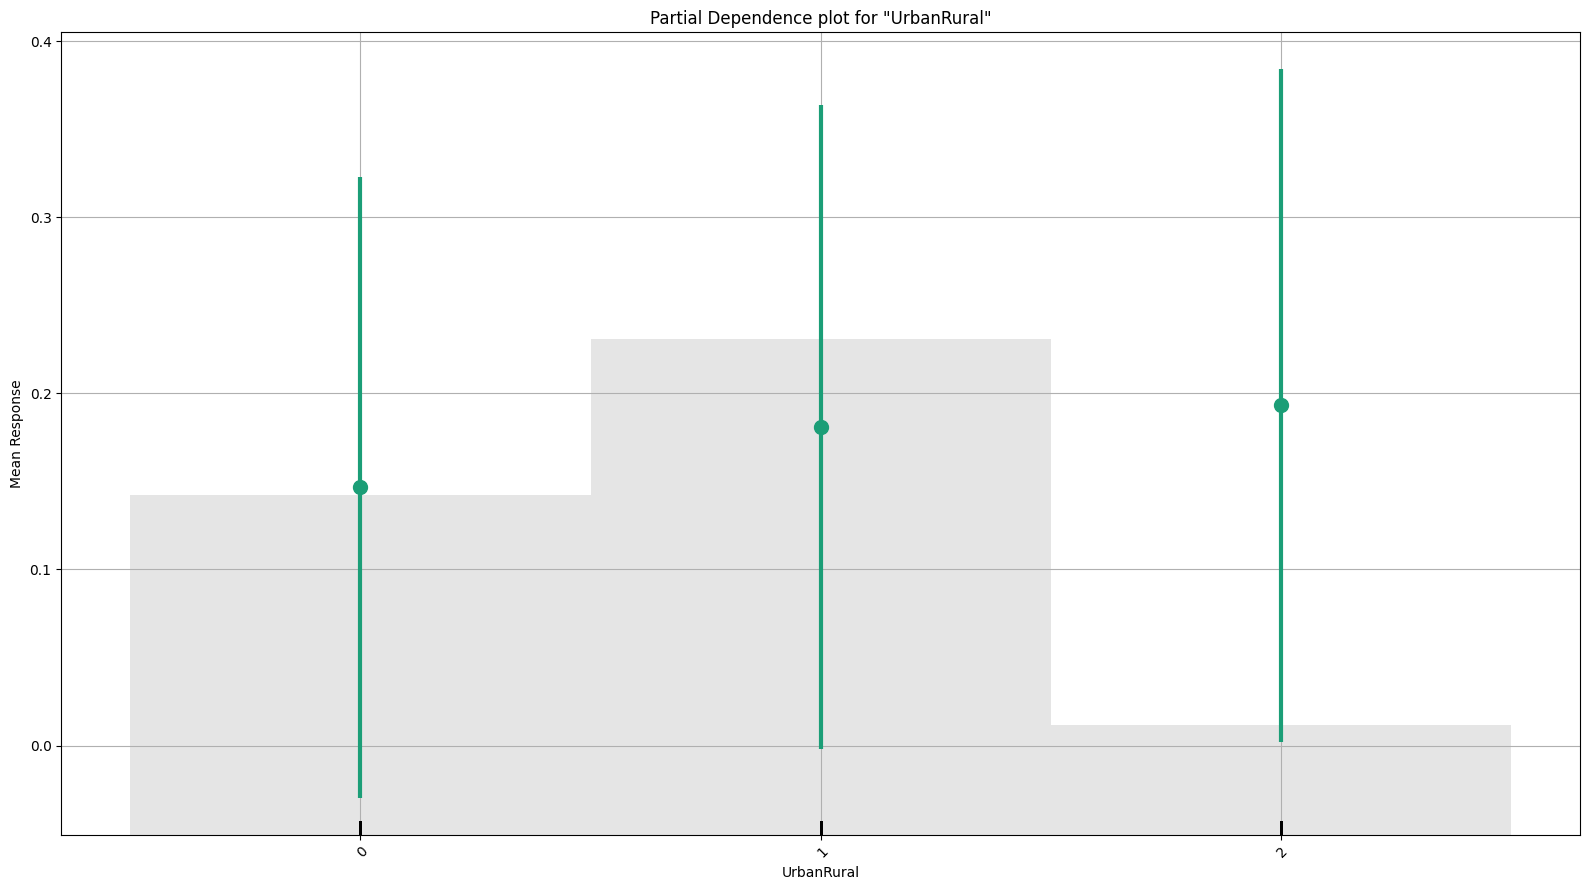

In [85]:
pd_plot = best_gbm.pd_plot(test_h2o[predictors], 'UrbanRural')
pd_plot

**PDP Plot for `SBAGrantRatio`**

From the partial dependence plot below, we can see that when `SBAGrantRatio` is lower, the average probability of default is higher, whereas when `SBAGrantRatio` is close to 1, the average probability of default goes down. This is expected because if `SBAGrantRatio` is close to 1, it means the SBA is guaranteeing a larger portion of the loan, and the small business will not have to pay back as much to the bank, which results in a lowered probability of default.


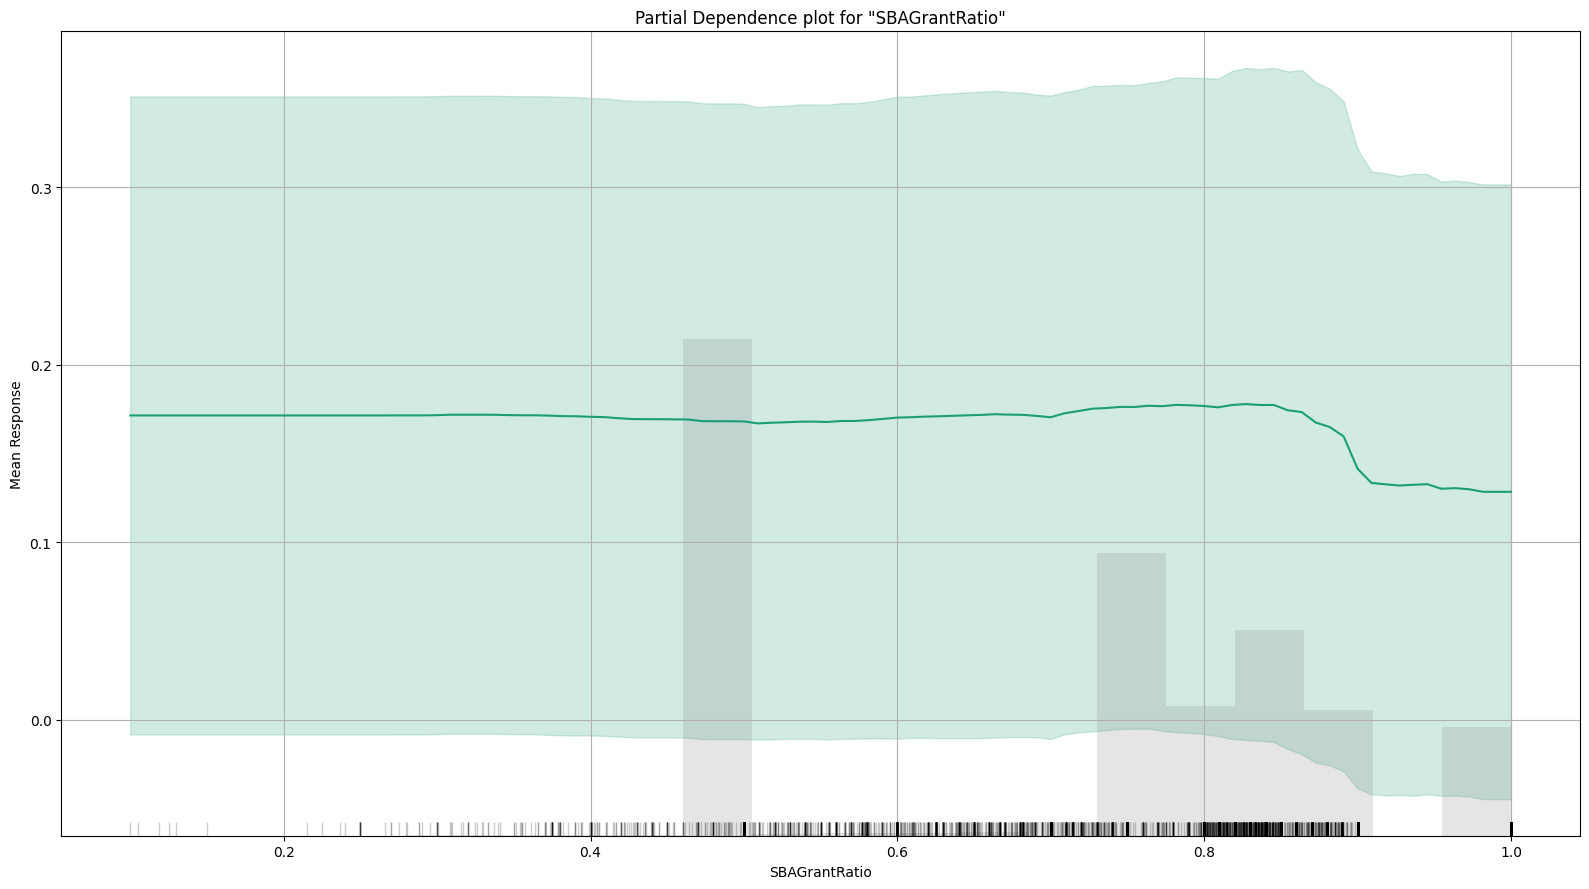

In [86]:
pd_plot = best_gbm.pd_plot(test_h2o[predictors], 'SBAGrantRatio')
pd_plot

## LightGBM

Now we will train and tune a LightGBM model.

First, we will create separate lists of the categorical columns and the numerical ones because LightGBM requires that we specify which columns are categorical. The target encoded columns will be considered numerical but the 0/1 columns (OHE and binary engineered features) will be considered categorical.

We will also define a list of predictors to train the model. The numerical version of `LoanInd` will be removed because it was determined previously that this variable is more useful when considered as categorical. 

In [88]:
# List of ohe columns
ohe_columns = [x for x in cat_enc_columns if x not in te_columns]

# List of 0/1 columns (ohe encoded and binary engineered features)
categorical_columns = ohe_columns + binary_columns

# Numerical Columns (including target encoded columns)
numerical_columns = numerical_cols + te_columns

# Removing LoanInd from numerical columns (using target encoded version assuming categorical)
numerical_columns.remove('LoanInd')

# Target column
response_column = 'MIS_Status'

# Full list of columns to train
cols_to_train = numerical_columns + categorical_columns

Below is a preview of the data that will be used for training:

In [89]:
X_train[cols_to_train].head()

,NoEmp,CreateJob,RetainedJob,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LogDisbursementGross,LogGrAppv,LogSBA_Appv,...,RevLineCr_N,RevLineCr_Y,LowDoc_Missing,LowDoc_N,LowDoc_Y,GrantDisbDifferent,GrantSBADifferent,CreateAnyJob,AnyEmp,AnyRetainedJob
300028,8,0,0,25000.0,0.0,25000.0,12500.0,10.126631,10.126631,9.433484,...,0.0,1.0,0.0,1.0,0.0,0,1,0,1,0
388438,3,0,0,90300.0,0.0,90300.0,72240.0,11.410893,11.410893,11.187749,...,1.0,0.0,0.0,1.0,0.0,0,1,0,1,0
621662,13,3,10,450000.0,0.0,450000.0,337500.0,13.017003,13.017003,12.729321,...,1.0,0.0,0.0,1.0,0.0,0,1,1,1,1
484631,1,6,6,215400.0,0.0,215400.0,161550.0,12.280252,12.280252,11.992570,...,1.0,0.0,0.0,1.0,0.0,0,1,1,1,1
429422,2,0,0,200000.0,0.0,200000.0,150000.0,12.206073,12.206073,11.918391,...,1.0,0.0,0.0,1.0,0.0,0,1,0,1,0


Full lsit of columns to train:

In [90]:
cols_to_train

['NoEmp',
 'CreateJob',
 'RetainedJob',
 'DisbursementGross',
 'BalanceGross',
 'GrAppv',
 'SBA_Appv',
 'LogDisbursementGross',
 'LogGrAppv',
 'LogSBA_Appv',
 'DisbGrAppvRatio',
 'SBAGrantRatio',
 'SBA_Appv^2',
 'City_trg',
 'State_trg',
 'Zip_trg',
 'Bank_trg',
 'BankState_trg',
 'NAICS_trg',
 'FranchiseCode_trg',
 'LoanIndCat_trg',
 'NAICS_Sector_trg',
 'NewExist_1.0',
 'NewExist_2.0',
 'NewExist_Missing',
 'UrbanRural_0',
 'UrbanRural_1',
 'UrbanRural_2',
 'RevLineCr_Missing',
 'RevLineCr_N',
 'RevLineCr_Y',
 'LowDoc_Missing',
 'LowDoc_N',
 'LowDoc_Y',
 'GrantDisbDifferent',
 'GrantSBADifferent',
 'CreateAnyJob',
 'AnyEmp',
 'AnyRetainedJob']

### Train LightGBM model with default parameters

First, a LightGBM model will be trained with default parameters to determine baseline performance.

In [91]:
import lightgbm as lgb

train_data = lgb.Dataset(data=X_train[cols_to_train], label=y_train, params={"verbose":-1}, categorical_feature=categorical_columns)
valid_data = lgb.Dataset(data=X_valid[cols_to_train], label=y_valid, params={"verbose":-1}, categorical_feature=categorical_columns)
lgb_clf = lgb.train(params={"verbose":-1},
                    train_set=train_data)

Using categorical_feature in Dataset.


The AUC on the test set is 82.106% which is about one percentage point higher than with the GBM model. The train, test, and validation AUCs are fairly similar to each other so there is not a significant amount of overfitting.

In [92]:
from sklearn.metrics import roc_auc_score
print("AUC score on Train dataset:", roc_auc_score(y_train, lgb_clf.predict(X_train[cols_to_train])))
print("AUC score on Validation dataset:", roc_auc_score(y_valid, lgb_clf.predict(X_valid[cols_to_train])))
print("AUC score on Test dataset:", roc_auc_score(y_test, lgb_clf.predict(X_test[cols_to_train])))

AUC score on Train dataset: 0.8555150306464971
AUC score on Validation dataset: 0.821816275852763
AUC score on Test dataset: 0.8210599240357765


### LightGBM Hyper-parameters tuning

Below we define the search grid that will be used to tune the model. The model will be tuned using optuna for 150 trials and the best model will be determined based on the AUC on the validation set.

In [93]:
from optuna.integration import LightGBMPruningCallback
import tqdm as notebook_tqdm
from sklearn.metrics import roc_auc_score
import optuna
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

def objective(trial, X, y):
    param_grid = {
        "num_iterations": 400,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.05),
        "num_leaves": trial.suggest_int("num_leaves", 50, 150, step=5),
        "max_depth": trial.suggest_int("max_depth", 5, 20, step=2),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 1000, step=100),
        
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.8, 1.0, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [5]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.8, 1.0, step=0.1),
        
        "is_unbalance": trial.suggest_categorical("is_unbalance",[True, False]),
        
        "verbose": -1,
        "objective":"binary",
        "metric":"auc"
    }
    
    train_data = lgb.Dataset(data=X_train[cols_to_train], label=y_train, params={"verbose":-1}, categorical_feature=categorical_columns)
    valid_data = lgb.Dataset(data=X_valid[cols_to_train], label=y_valid, params={"verbose":-1}, categorical_feature=categorical_columns)

    lgb_clf = lgb.train(params=param_grid,
                        train_set=train_data,
                        valid_sets=[valid_data],
                        categorical_feature=categorical_columns,
                        callbacks=[LightGBMPruningCallback(trial, "auc"),
                                    lgb.early_stopping(stopping_rounds=5)]  
                        )
    pred = lgb_clf.predict(X_valid[cols_to_train])
    
    auc_score = roc_auc_score(y_valid, pred)
    
    return auc_score

Starting the Optuna study:

In [94]:
import lightgbm as lgb
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_train[cols_to_train], y_train)
study.optimize(func, n_trials=150)

[I 2023-05-07 11:44:58,675] A new study created in memory with name: LGBM Classifier
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.825906


[I 2023-05-07 11:45:15,692] Trial 0 finished with value: 0.8259058789250716 and parameters: {'learning_rate': 0.11, 'num_leaves': 85, 'max_depth': 15, 'min_data_in_leaf': 200, 'lambda_l1': 2.873012571450599e-05, 'lambda_l2': 2.6872010214148947, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': False}. Best is trial 0 with value: 0.8259058789250716.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.825165


[I 2023-05-07 11:45:24,075] Trial 1 finished with value: 0.8251653190695376 and parameters: {'learning_rate': 0.21000000000000002, 'num_leaves': 135, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 6.44116081234038e-05, 'lambda_l2': 4.204989333288429e-06, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 0 with value: 0.8259058789250716.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[119]	valid_0's auc: 0.819059


[I 2023-05-07 11:45:37,195] Trial 2 finished with value: 0.8190591921238799 and parameters: {'learning_rate': 0.11, 'num_leaves': 100, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 1.7361653865639884e-06, 'lambda_l2': 0.058501334271314084, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.8, 'is_unbalance': True}. Best is trial 0 with value: 0.8259058789250716.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[335]	valid_0's auc: 0.817728


[I 2023-05-07 11:46:29,863] Trial 3 finished with value: 0.817727931016887 and parameters: {'learning_rate': 0.01, 'num_leaves': 85, 'max_depth': 19, 'min_data_in_leaf': 100, 'lambda_l1': 0.005599493993860041, 'lambda_l2': 4.855505288744609e-08, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 1.0, 'is_unbalance': False}. Best is trial 0 with value: 0.8259058789250716.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.825783


[I 2023-05-07 11:46:38,237] Trial 4 finished with value: 0.8257828794315305 and parameters: {'learning_rate': 0.21000000000000002, 'num_leaves': 115, 'max_depth': 13, 'min_data_in_leaf': 1000, 'lambda_l1': 0.00011985785476841092, 'lambda_l2': 2.496798022465512e-05, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': True}. Best is trial 0 with value: 0.8259058789250716.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 11:46:40,026] Trial 5 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.co

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.826712


[I 2023-05-07 11:46:51,154] Trial 6 finished with value: 0.8267117931247019 and parameters: {'learning_rate': 0.16000000000000003, 'num_leaves': 125, 'max_depth': 11, 'min_data_in_leaf': 300, 'lambda_l1': 0.5826641564601994, 'lambda_l2': 0.02343861036794983, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': True}. Best is trial 6 with value: 0.8267117931247019.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:01:37,522] Trial 7 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optun

Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:01:40,876] Trial 8 pruned. Trial was pruned at iteration 2.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:01:43,830] Trial 9 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.825712


[I 2023-05-07 12:01:55,997] Trial 10 finished with value: 0.82571199122218 and parameters: {'learning_rate': 0.26, 'num_leaves': 120, 'max_depth': 17, 'min_data_in_leaf': 300, 'lambda_l1': 1.0987747360688628e-08, 'lambda_l2': 0.003482197120502606, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 1.0, 'is_unbalance': True}. Best is trial 6 with value: 0.8267117931247019.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:01:58,023] Trial 11 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:02:13,021] Trial 13 pruned. Trial was pruned at iteration 37.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:02:15,318] Trial 14 pruned. Trial was pruned at iteration 2.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:02:17,298] Trial 15 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:02:19,314] Tria

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.827739


[I 2023-05-07 12:02:27,785] Trial 17 finished with value: 0.8277387925823063 and parameters: {'learning_rate': 0.26, 'num_leaves': 135, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.2761158002435237, 'lambda_l2': 0.5718128475689107, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 17 with value: 0.8277387925823063.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.828527


[I 2023-05-07 12:02:40,202] Trial 18 finished with value: 0.8285271227793491 and parameters: {'learning_rate': 0.26, 'num_leaves': 130, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.2567596096812227, 'lambda_l2': 0.0417422426482743, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.823062


[I 2023-05-07 12:02:45,291] Trial 19 finished with value: 0.8230615623282445 and parameters: {'learning_rate': 0.26, 'num_leaves': 135, 'max_depth': 9, 'min_data_in_leaf': 100, 'lambda_l1': 0.05371941976688478, 'lambda_l2': 0.5202183528001016, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:02:46,901] Trial 20 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rel

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	valid_0's auc: 0.827387


[I 2023-05-07 12:02:53,332] Trial 21 finished with value: 0.827386798916071 and parameters: {'learning_rate': 0.21000000000000002, 'num_leaves': 130, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.1868505421554314, 'lambda_l2': 0.019135692621700368, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:02:55,177] Trial 22 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/o

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.82672


[I 2023-05-07 12:03:09,230] Trial 24 finished with value: 0.826720418332749 and parameters: {'learning_rate': 0.26, 'num_leaves': 150, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.15233952703605025, 'lambda_l2': 0.0005017181380712704, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:03:11,218] Trial 25 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:03:15,921] Trial 27 pruned. Trial was pruned at iteration 4.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:03:17,794] Trial 28 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:03:21,759] Trial 29 pruned. Trial was pruned at iteration 14.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:03:23,446] Trial 30 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	valid_0's auc: 0.82679


[I 2023-05-07 12:03:30,453] Trial 31 finished with value: 0.8267901368302378 and parameters: {'learning_rate': 0.26, 'num_leaves': 150, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.1561587461946621, 'lambda_l2': 0.0005472279601134288, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:03:33,590] Trial 32 pruned. Trial was pruned at iteration 14.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:03:36,706] Trial 33 pruned. Trial was pruned at iteration 11.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:03:39,057] Trial 34 pruned. Trial was pruned at iteration 2.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:03:40,655] Trial 35 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:03:42,469] Tria

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.82672


[I 2023-05-07 12:03:55,177] Trial 41 finished with value: 0.8267203146942269 and parameters: {'learning_rate': 0.26, 'num_leaves': 150, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.14808645171960133, 'lambda_l2': 0.0007055128342068385, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.825372


[I 2023-05-07 12:04:01,505] Trial 42 finished with value: 0.8253724795204532 and parameters: {'learning_rate': 0.26, 'num_leaves': 150, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 0.42153453073574126, 'lambda_l2': 0.0004397468179696933, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:04:03,368] Trial 43 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:04:05,187] Trial 44 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:04:06,984] Trial 45 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been depr

Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:04:16,643] Trial 50 pruned. Trial was pruned at iteration 1.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.827403


[I 2023-05-07 12:04:27,909] Trial 51 finished with value: 0.827403173802567 and parameters: {'learning_rate': 0.26, 'num_leaves': 150, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.12405375371374326, 'lambda_l2': 0.0004983904667280438, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.827281


[I 2023-05-07 12:04:38,748] Trial 52 finished with value: 0.8272813942207967 and parameters: {'learning_rate': 0.26, 'num_leaves': 145, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.0982621500094005, 'lambda_l2': 0.0005248532417554232, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.828298


[I 2023-05-07 12:04:47,333] Trial 53 finished with value: 0.8282982549161039 and parameters: {'learning_rate': 0.26, 'num_leaves': 145, 'max_depth': 13, 'min_data_in_leaf': 200, 'lambda_l1': 0.08368429509440556, 'lambda_l2': 0.0009065004922098779, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:04:49,114] Trial 54 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.826985


[I 2023-05-07 12:05:07,607] Trial 61 finished with value: 0.8269852951845935 and parameters: {'learning_rate': 0.26, 'num_leaves': 145, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.11604335576555948, 'lambda_l2': 0.0005995129187574195, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.82787


[I 2023-05-07 12:05:13,690] Trial 62 finished with value: 0.8278702310584254 and parameters: {'learning_rate': 0.26, 'num_leaves': 145, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.08011463083756906, 'lambda_l2': 0.001433278135872232, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:05:15,774] Trial 63 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:05:24,266] Trial 68 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:05:25,920] Trial 69 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been depr

Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:05:35,632] Trial 74 pruned. Trial was pruned at iteration 12.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:05:37,545] Trial 75 pruned. Trial was pruned at iteration 3.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:05:39,182] Trial 76 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:05:42,193] Trial 77 pruned. Trial was pruned at iteration 8.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:05:43,986] Trial 78 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.827493


[I 2023-05-07 12:05:51,020] Trial 79 finished with value: 0.8274932097686645 and parameters: {'learning_rate': 0.26, 'num_leaves': 145, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 0.03566920103703913, 'lambda_l2': 7.659327514553302e-05, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:05:52,729] Trial 80 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.827931


[I 2023-05-07 12:05:58,824] Trial 81 finished with value: 0.8279312293458885 and parameters: {'learning_rate': 0.26, 'num_leaves': 145, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 0.026492573796494372, 'lambda_l2': 0.0004359004801629767, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:06:03,153] Trial 82 pruned. Trial was pruned at iteration 14.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:06:06,860] Trial 83 pruned. Trial was pruned at iteration 8.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:06:08,670] Trial 84 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:06:10,386] Tria

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.825313


[I 2023-05-07 12:06:17,118] Trial 86 finished with value: 0.8253128636197358 and parameters: {'learning_rate': 0.26, 'num_leaves': 140, 'max_depth': 13, 'min_data_in_leaf': 100, 'lambda_l1': 0.4755310142864094, 'lambda_l2': 6.665959485373701e-05, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': True}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:06:19,092] Trial 87 pruned. Trial was pruned at iteration 1.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:06:21,232] Trial 88 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:06:23,362] Tria

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.826924


[I 2023-05-07 12:06:33,373] Trial 91 finished with value: 0.8269243476368237 and parameters: {'learning_rate': 0.26, 'num_leaves': 145, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.11475776814305717, 'lambda_l2': 0.0012575421560173953, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:06:35,342] Trial 92 pruned. Trial was pruned at iteration 1.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:06:37,082] Trial 93 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:06:39,064] Tria

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.827592


[I 2023-05-07 12:06:47,483] Trial 96 finished with value: 0.827591904949199 and parameters: {'learning_rate': 0.26, 'num_leaves': 150, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 0.40721757229967404, 'lambda_l2': 0.000422247675432752, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:06:48,989] Trial 97 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:06:50,850] Trial 98 pruned. Trial was pruned at iteration 2.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:06:52,580] Trial 99 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:06:54,246] Trial 100 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:06:55,951] Trial 101 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been de

Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:06:59,362] Trial 103 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:00,970] Trial 104 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been de

Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:07:07,955] Trial 106 pruned. Trial was pruned at iteration 31.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:09,575] Trial 107 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:11,283] T

Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:12,904] Trial 109 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:14,572] Trial 110 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:07:16,683] Trial 111 pruned. Trial was pruned at iteration 3.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:18,432] Trial 112 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:20,153] Trial 113 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:21,807] Trial 114 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:23,381] Trial 115 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:07:25,426] Trial 116 pruned. Trial was pruned at iteration 3.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:27,184] Trial 117 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:07:30,885] Trial 118 pruned. Trial was pruned at iteration 14.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:32,579] Trial 119 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:34,222] T

Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:37,812] Trial 122 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:39,404] Trial 123 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:41,134] Trial 124 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been de

Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:44,943] Trial 126 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.825362


[I 2023-05-07 12:07:50,502] Trial 127 finished with value: 0.8253620141888542 and parameters: {'learning_rate': 0.26, 'num_leaves': 150, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 0.040900511258192516, 'lambda_l2': 1.0579031604155964, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:52,365] Trial 128 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:54,045] Trial 129 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:55,685] Trial 130 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been de

Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:07:59,747] Trial 132 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:08:06,494] Trial 133 pruned. Trial was pruned at iteration 26.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:08:13,150] Trial 134 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:08:15,343] T

Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:08:17,384] Trial 136 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:08:19,350] Trial 137 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been de

Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:08:24,717] Trial 139 pruned. Trial was pruned at iteration 11.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:08:35,023] Trial 140 pruned. Trial was pruned at iteration 32.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:08:37,310] Trial 141 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.826924


[I 2023-05-07 12:08:43,813] Trial 142 finished with value: 0.8269244167291717 and parameters: {'learning_rate': 0.26, 'num_leaves': 145, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.11197340888914613, 'lambda_l2': 0.002707658126928134, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.82787


[I 2023-05-07 12:08:50,572] Trial 143 finished with value: 0.827870184637004 and parameters: {'learning_rate': 0.26, 'num_leaves': 145, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.08004080941492439, 'lambda_l2': 0.002900932856253331, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:08:52,229] Trial 144 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.827935


[I 2023-05-07 12:08:58,453] Trial 145 finished with value: 0.8279349068940719 and parameters: {'learning_rate': 0.26, 'num_leaves': 145, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 0.0839318344631512, 'lambda_l2': 0.011461735526408489, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}. Best is trial 18 with value: 0.8285271227793491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:09:00,206] Trial 146 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 5 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:09:01,940] Trial 147 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


Training until validation scores don't improve for 5 rounds


[I 2023-05-07 12:09:04,784] Trial 148 pruned. Trial was pruned at iteration 8.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-05-07 12:09:06,317] Trial 149 pruned. Trial was pruned at iteration 0.


The parameters for the best model are shown below:

In [95]:
print(f"\tBest value (AUC): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AUC): 0.82853
	Best params:
		learning_rate: 0.26
		num_leaves: 130
		max_depth: 9
		min_data_in_leaf: 200
		lambda_l1: 0.2567596096812227
		lambda_l2: 0.0417422426482743
		bagging_fraction: 1.0
		bagging_freq: 5
		feature_fraction: 0.9
		is_unbalance: False


In [96]:
best_params = {"verbose": -1,
                "objective":"binary",
                "metric":"auc"
            }
for key,val in study.best_params.items():
    best_params[key] = val

print(best_params)

{'verbose': -1, 'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.26, 'num_leaves': 130, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.2567596096812227, 'lambda_l2': 0.0417422426482743, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.9, 'is_unbalance': False}


### Train Model with parameters found using Optuna

Now the final model will be trained using the parameters found using Optuna.

In [97]:
train_data = lgb.Dataset(data=X_train[cols_to_train], label=y_train, params={"verbose":-1}, categorical_feature=categorical_columns)
test_data = lgb.Dataset(data=X_test[cols_to_train], label=y_test, params={"verbose":-1}, categorical_feature=categorical_columns)
best_lgb = lgb.train(params=best_params,
                    train_set=train_data) 

### LightGBM Model Performance

#### AUC score

Below are the AUC scores an the train, test, and validation sets.

In [98]:
print("AUC score on Train dataset:", roc_auc_score(y_train, best_lgb.predict(X_train[cols_to_train])))
print("AUC score on Test dataset:", roc_auc_score(y_test, best_lgb.predict(X_test[cols_to_train])))
print("AUC score on Validation dataset:", roc_auc_score(y_valid, best_lgb.predict(X_valid[cols_to_train])))

AUC score on Train dataset: 0.8894952220439885
AUC score on Test dataset: 0.8275400938476309
AUC score on Validation dataset: 0.828193475290666


Now we will calculate the threshold to maximize the F1 score on the test set.

In [99]:
pred_probabilities = best_lgb.predict(X_test[cols_to_train])

In [100]:
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities)

# Calculate index for the best probability threshold
best_f1 = 0
best_f1_id = 0
for id,threshold in enumerate(thresholds):
    f1 = f1_score(pred_probabilities >= threshold, y_test, average = 'macro')
    if f1 > best_f1:
        best_f1 = f1
        best_f1_id = id

print("Best f1:", best_f1)
best_threshold = thresholds[best_f1_id]
print("Threshold for best F1:", best_threshold)

Best f1: 0.712631973264479
Threshold for best F1: 0.31744460487434883


#### Obtaining Labels

The predicted labels are calculated using the threshold value found above.

In [101]:
# Apply threshold to come up with class
pred_class_tf = pred_probabilities >= best_threshold

# Apply threshold to predict class
y_pred_test = pred_class_tf.astype(np.int16)

In [102]:
# Creating pandas dataframe to show probabilities and true and predicted labels
p1 = pred_probabilities
p0 = 1 - pred_probabilities

LGB_preds = pd.DataFrame({'p1': p1, 'p0': p0, 'y_true': y_test, 'y_pred':y_pred_test})

In [103]:
LGB_preds.head()

,p1,p0,y_true,y_pred
251392,0.298824,0.701176,1,0
240480,0.293492,0.706508,1,0
397733,0.044532,0.955468,0,0
749439,0.099209,0.900791,0,0
16929,0.198632,0.801368,1,0


#### Confusion Matrix of Test Set

In [127]:
from sklearn.metrics import confusion_matrix

# Printing confusion matrix
print('Confusion matrix for the test set:')
print(confusion_matrix(y_test,y_pred_test))

Confusion matrix for the test set:
[[59198  7367]
 [ 6420  7760]]


## LightGBM Model Interpretation 

The LighGBM model will be interpreted using a variety of different methods including an analysis of global and permutation feature importances, an analysis of summary shapley values, and finally an examination of individual records' shapley values to determine how each feature contributes to the model prediction.

#### Default Feature Importance

According to the default feature importance plot, the five most important features for the LightGBM model are `Bank`, `Zip`, `SBAGrantRatio`, `FranchiseCode` and `NAICS`. These are similar in order of importance to the default feature importances obtained with the H2O model. We expect these features to have high importance because, as mentioned previously, the strictness of each bank's loan policy will be highly correlated with the incidence of loan default at that bank. `Zip` is important because it indicates the specific location of the small business which is expected to have a correlation with business success and therefore, loan default. `SBAGrantRatio` tells us what portion of the loan taken out by the small business was guaranteed by the SBA. If the SBA guarantees a larger portion we expect loan default to go down since the business itself does not have to pay back the full amount of the loan. `FranchiseCode` is also expected to be important because the type of franchise is a good indicator of whether that business is successful which has a direct effect on the probability of defaulting on their loan. `NAICS` is important because it indicates what industry the small business is in and since in certain industries starting a small business is more risky than in others, this is expected to correlate with how well the business does and whether it will be able to pay back their loan.

As mentioned previously, these importances may be biased, so the permutation feature importances will also be analyzed in the next section.

100%|===================| 80668/80745 [16:00<00:00]        

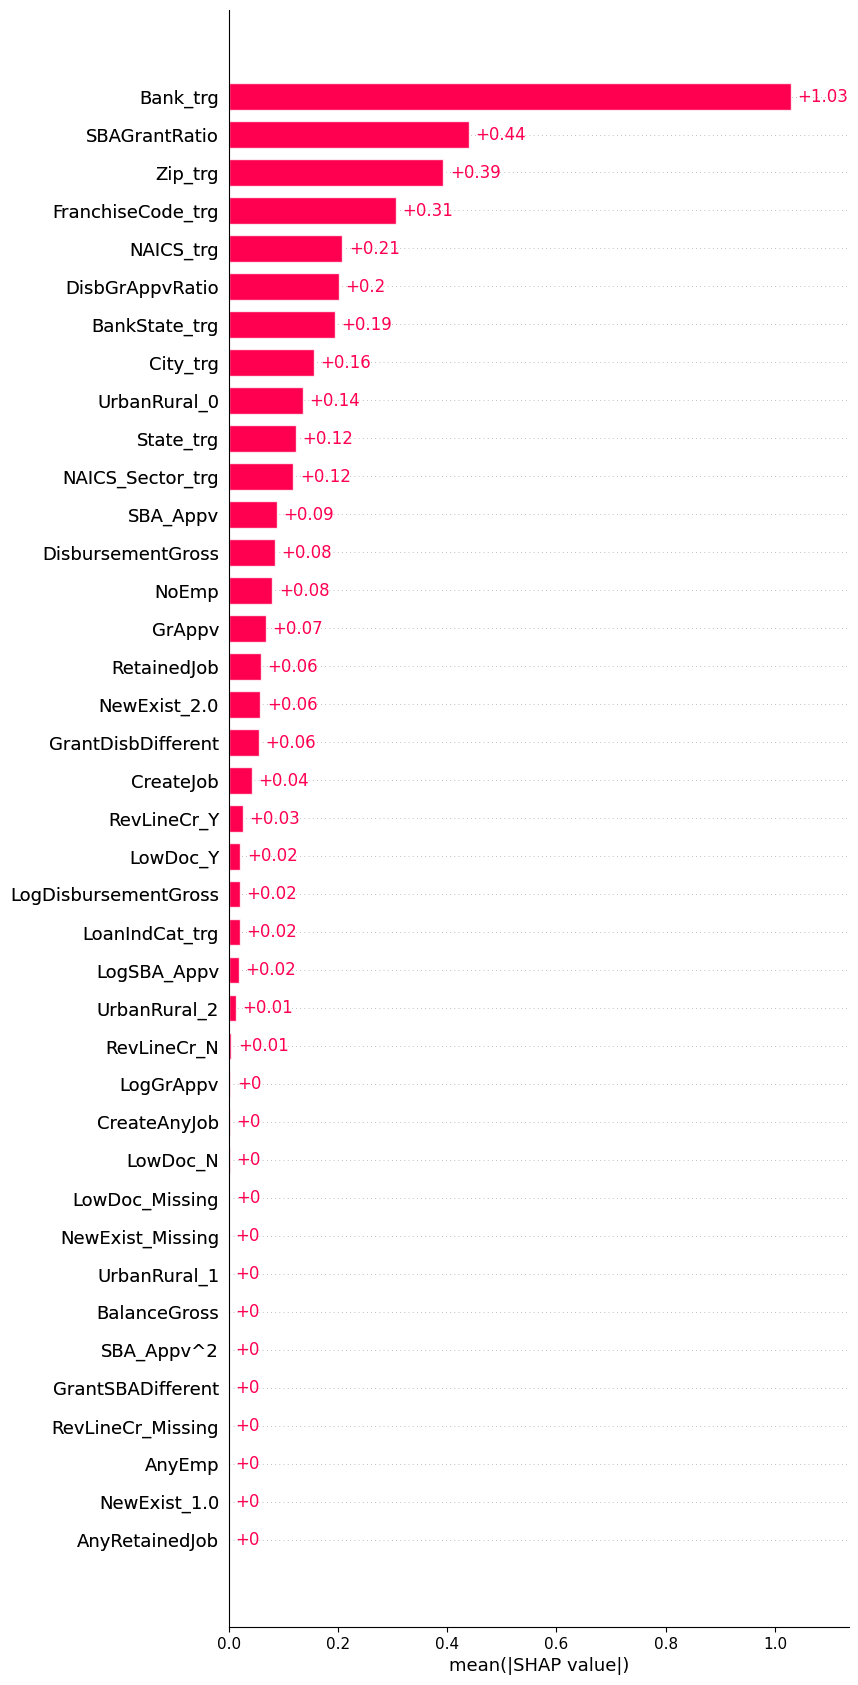

In [104]:
import shap

# Compute SHAP values
explainer = shap.Explainer(best_lgb, X_test[cols_to_train]) 
shap_values = explainer(X_test[cols_to_train], check_additivity=False)

# Plot global feature importance
shap.plots.bar(shap_values, max_display = X_test[cols_to_train].shape[1])

#### Permutation Feature Importance

The permutation feature importance plot shows very similar importances to the default feature importance plot. However, now `RevLineCr_N` (the one-hot-encoded variable indicating if the loan is not of the type with a revolving line of credit) is now fifth on the list in order of importance, whereas in the default plot it was 23rd. This is an important feature because whether the loan is of revolving line of credit type determines whether or not the interest is paid on the full amount of the loan or just on the amount borrowed when needed. The first scenario may make it more difficult for borrowers to pay back the interest and could increase the probability of loan default. However, the permutation importance plot does not show whether the impact of this feature is mostly positive or negative. To determine this we will generate a summary plot of shapley values and analyze the effects in more detail.

Permutation explainer: 10001it [31:20,  5.31it/s]                                                                      


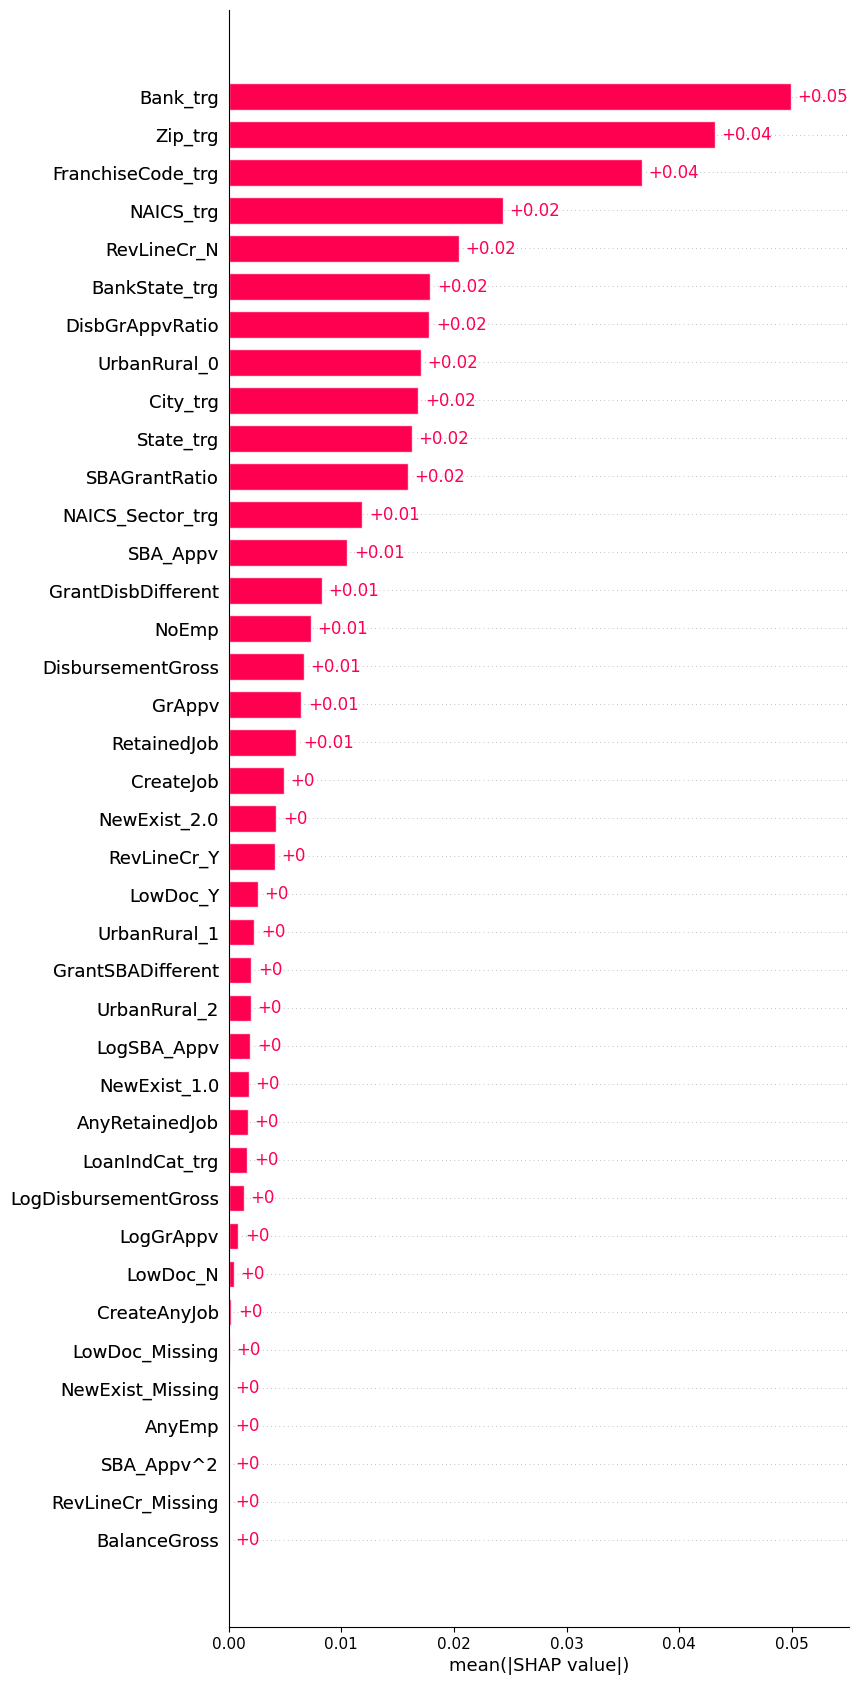

In [105]:
# build a Permutation explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Permutation(best_lgb.predict, X_test[cols_to_train].sample(n=10000, random_state=56))
shap_values = explainer(X_test[cols_to_train].sample(n=10000, random_state=56))
shap.plots.bar(shap_values, max_display = X_test[cols_to_train].shape[1])

#### Shapley Summary Plot

The summary shapley plot shows the summary contributions of each feature. To avoid overplotting, 50,000 records were randomly sampled from the data.

As was the case with the GBM shapley summary plot, most features that were target encoded tend to show lower target encoded values producing more negative shapley contributions and higher target encoded values producing more positive shapley contributions.

The `Bank` feature is again the most important, followed by `Zip`, `FranchiseCode`, `SBAGrantRatio` and `DisbGrAppvRatio`.

When `SBAGrantRatio` is high the feature tends to produce more negative shapley contributions.

`DisbGrAppvRatio` tends to produce negative shapley contributions for low values of the ratio and positive contributions for higher ratios. This is expected because if the bank disbursed a higher amount than what was approved it is not surprising that the probability of default would increase.

Interestingly, `LoanIndCat` feature is not very important for the LightGBM model, but it was ranked fifth in order of importance in the GBM summary plot.


100%|===================| 49993/50000 [09:54<00:00]        

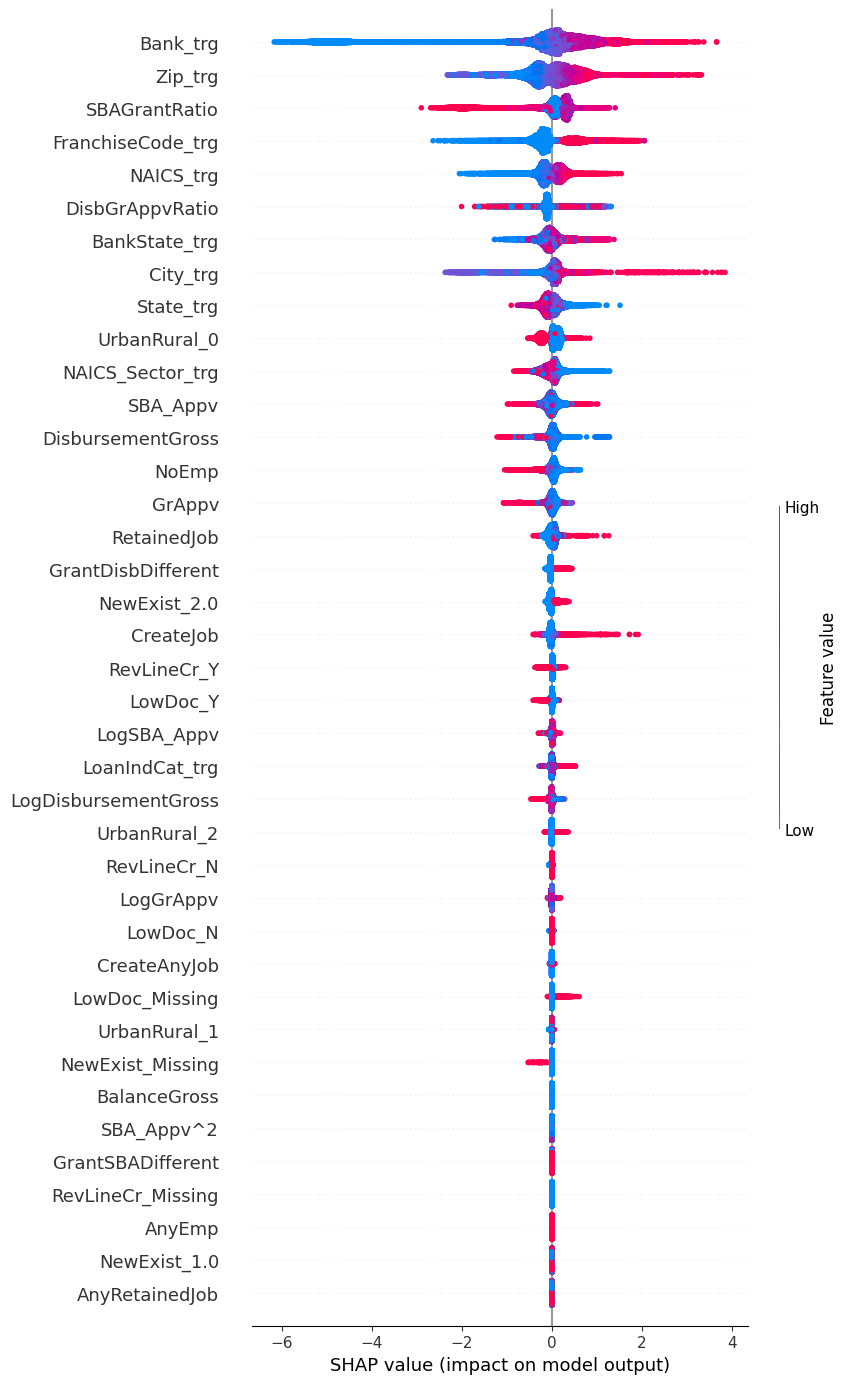

In [106]:
import shap

# Compute SHAP values
explainer = shap.Explainer(best_lgb, X_test[cols_to_train].sample(n=50000, random_state=56)) 
shap_values = explainer(X_test[cols_to_train].sample(n=50000, random_state=56), check_additivity=False)

# Get summary plot
shap.plots.beeswarm(shap_values, max_display=X_test[cols_to_train].shape[1])

#### Examining individual records

In [107]:
# load JS visualization code to notebook
shap.initjs()

In [108]:
def single_record_shapley_plot(model, data, record_index, feature_list):
    
    explainer = shap.Explainer(model, data) 
    shap_values = explainer(data.loc[record_index]).values
    bias_term = explainer.expected_value

    return shap.force_plot(bias_term,
                           shap_values,
                           data.loc[record_index].values,
                           feature_list,
                           link="logit",
                           matplotlib=False)

#### Analysis of two true-negative records

Selecting two random rows of X_test where the target variable was correctly predicted as 0 with high probability (p0 > 0.9).

In [109]:
# outputting 2 random rows of X_test where label 0 was correctly predicted
X_test[(LGB_preds['y_true'] == 0) & (LGB_preds['y_pred'] == 0) & (LGB_preds['p0'] > 0.9)].sample(n=2, random_state=56)

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,...,LowDoc_Y,City_trg,State_trg,Zip_trg,Bank_trg,BankState_trg,NAICS_trg,FranchiseCode_trg,LoanIndCat_trg,NAICS_Sector_trg
631887,631887,PORTLAND,OR,97212,WELLS FARGO BANK NATL ASSOC,SD,0,91,1.0,0,...,0.0,0.141432,0.152068,0.099620,0.141479,0.180389,0.083279,0.123076,0.176827,0.083279
66477,66477,HOLLY POND,AL,35083,SOUTHERN DEVELOPMENT COUNCIL,AL,0,15,2.0,15,...,0.0,0.137979,0.167441,0.143552,0.000000,0.131183,0.083279,0.123076,0.177425,0.083279


In [130]:
single_record_shapley_plot(best_lgb, X_test[cols_to_train], 631887, cols_to_train)

**Record 631887 (TN):** The largest contribution is negative from the `Zip` feature. The second largest is positive from the `Bank` feature, followed by `SBAGrantRatio` which is also positive and then `NoEmp`= 91 which is contributing negatively. The model was able to correctly predict no default mainly using the `Zip` and `FranchiseCode` features which were likely indicating a zip code and franchise wherein most businesses did not default on their loan, the `NoEmp` feature, which for higher values generally leads to a lower probability of default. 

In [131]:
single_record_shapley_plot(best_lgb, X_test[cols_to_train], 66477, cols_to_train)

**Record 66477 (TN):** For this record, most significant contributions were negative. The largest contributor was `Bank`, followed by `SBAGrantRatio`= 1, and `Zip`. 

#### Analysis of two false-negative records

Selecting two random rows of X_test where the target variable is 1 but the model incorrectly predicted 0 with high probability (p0 > 0.9).

In [112]:
# outputting 2 random rows of X_test where true y is 1 but model predicted 0
X_test[(LGB_preds['y_true'] == 1) & (LGB_preds['y_pred'] == 0) & (LGB_preds['p0'] > 0.9)].sample(n=2, random_state=56)

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,...,LowDoc_Y,City_trg,State_trg,Zip_trg,Bank_trg,BankState_trg,NAICS_trg,FranchiseCode_trg,LoanIndCat_trg,NAICS_Sector_trg
459611,459611,MISHAWAKA,IN,46545,"PNC BANK, NATIONAL ASSOCIATION",DE,453310,9,2.0,6,...,0.0,0.141668,0.177927,0.159109,0.192002,0.252836,0.245085,0.077844,0.176827,0.228862
591527,591527,MILESBURG,PA,16853,MANUFACTURERS & TRADERS TR CO,NY,0,9,1.0,0,...,0.0,0.143552,0.145809,0.173819,0.127733,0.167931,0.083279,0.123076,0.173849,0.083279


In [132]:
single_record_shapley_plot(best_lgb, X_test[cols_to_train], 459611, cols_to_train)

**Record 459611 (FN):** The highest negative contribution is from `FranchiseCode`. It is likely that many businesses sharing the same franchise code paid the loan in full but in this partibular case the business defaulted on their loan and the model had difficulty predicting default in this scenario. The `SBAGrantRatio` feature is contributing positively to the model prediction with the second largest magnitude after `FranchiseCode`. However, the contribution and other positive contributions like `Bank` were not sufficient to result in a prediction of loan default.

In [133]:
single_record_shapley_plot(best_lgb, X_test[cols_to_train], 591527, cols_to_train)

**Record 591527 (FN):** `City` is contributing significantly in the negative direction and it is the main feature causing the model to incorrectly predict that the business would not default on their loan. The model has difficulty predicting default when the city is shared by many other records for businesses who did not default on their loan. `SBAGrantRatio` is contributing in the positive direction because its value is less than 1, which generally increases the probability of default, however, its shapley contribution, and that of other features with positive shapley values was not sufficient to lead to a correct prediction.

#### Analysis of two true-positive records

Selecting two random rows of X_test where the target variable was correctly predicted as 1 with high probability (p1 > 0.9).

In [115]:
# outputting 2 random rows of X_test where label was correctly predicted as 1
X_test[(LGB_preds['y_true'] == 1) & (LGB_preds['y_pred'] == 1) & (LGB_preds['p1'] > 0.9)].sample(n=2, random_state=56)

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,...,LowDoc_Y,City_trg,State_trg,Zip_trg,Bank_trg,BankState_trg,NAICS_trg,FranchiseCode_trg,LoanIndCat_trg,NAICS_Sector_trg
295444,295444,SAN ANTONIO,TX,78218,FIRST COMM. BANK NATL ASSOC,TX,0,5,1.0,0,...,0.0,0.179762,0.188343,0.097939,0.311111,0.138985,0.083279,0.342487,0.176917,0.083279
112490,112490,CAMAS,WA,98607,BANK OF AMERICA NATL ASSOC,NC,522310,1,1.0,2,...,0.0,0.273318,0.141541,0.245894,0.274753,0.293402,0.484914,0.342487,0.177425,0.288853


In [134]:
single_record_shapley_plot(best_lgb, X_test[cols_to_train], 295444, cols_to_train)

**Record 295444 (TP):** Almost all features are contributing positively to this correct prediction of default. The largest contributor is `Bank`, followed by `FranchiseCode`, and `NAICS`. From this prediction and others analyzed above, it can be observed that when the true target value is 1 (defauted) `Bank` is almost always contributing positively and to a significant degree, even though the contribution does not always result in a positive prediction. For example in record 459611 analyzed above, the true target value was 1 and `Bank` had one of the highest positive contributions but the model still incorrectly predicted 0 because there were other features contributing negatively with a higher cumulative magnitude. In this particular case, there are barely any negative contributions so the model is correctly predicting default.

In [135]:
single_record_shapley_plot(best_lgb, X_test[cols_to_train], 112490, cols_to_train)

**Record 112490 (TP):** This record has very few negative contributions to the prediction. The largest contributions are positive from `Bank`, `NAICS`, `FranchiseCode`, and `Zip`. As expected, `Bank` has a high positive contribution as has almost always been the case when the true label is 1. `NAICS` is also contributing significantly, as is `FranchiseCode`.

#### Analysis of two false-positive records

Selecting two random rows of X_test where the target variable is 0 but the model incorrectly predicted 1 with high probability (p1 > 0.9).

In [118]:
# outputting 2 random rows of X_test where true y is 0 but model predicted 1
X_test[(LGB_preds['y_true'] == 0) & (LGB_preds['y_pred'] == 1) & (LGB_preds['p1'] > 0.9)].sample(n=2, random_state=56)

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,...,LowDoc_Y,City_trg,State_trg,Zip_trg,Bank_trg,BankState_trg,NAICS_trg,FranchiseCode_trg,LoanIndCat_trg,NAICS_Sector_trg
588955,588955,HINDSBORO,IL,61930,U.S. BANK NATIONAL ASSOCIATION,IL,0,1,1.0,0,...,0.0,0.175583,0.227937,0.282846,0.175146,0.223076,0.083279,0.342487,0.177425,0.083279
704165,704165,Washougal,WA,98671,KEYBANK NATIONAL ASSOCIATION,OH,236118,1,1.0,0,...,0.0,0.282846,0.141541,0.236047,0.119288,0.159508,0.414860,0.342487,0.174233,0.233584


In [136]:
single_record_shapley_plot(best_lgb, X_test[cols_to_train], 588955, cols_to_train)

**Record 588955 (FP):** For this record, the features conributing the most to the false positive prediction are `Zip`, and `FranchiseCode`, and `Bank`. Consistently the `Bank` and `FranchiseCode` features tend to be very high contributors whether in the positive or negative direction and often determine in large part what the final prediction will be. Unfortunately, as in this case, these features do not always contribute in the correct direction, indicating that perhaps some more advanced feature engineering was needed to create features that might be better at predicting the correct outcome when an observation deviates from the norm.

In [137]:
single_record_shapley_plot(best_lgb, X_test[cols_to_train], 704165, cols_to_train)

**Record 704165 (FP):** This record is seeing significant positive contributions from  `City`, `Bank`, and `State` and almost no negative contributions which causes it to predict label 1 (default) even though the true label is 0. The model is incorrectly predicting default because it is likely that many businesses sharing the same city, bank, and state defaulted on their loans and the model was unable to use any other features to predict this outcome which may be unusual for this combination of `City`, `Bank` and `State` values. 

#### Feature Interaction Graphs

 99%|===================| 9917/10000 [02:00<00:01]        

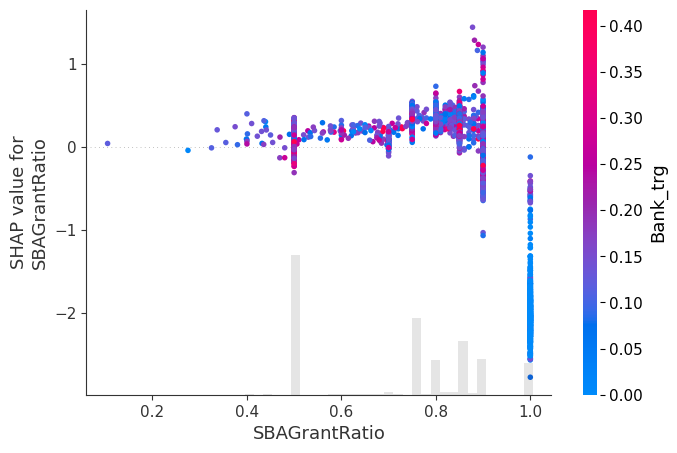

In [121]:
import shap

# Compute SHAP values
explainer = shap.Explainer(best_lgb, X_test[cols_to_train].sample(n=10000, random_state=56)) 
shap_values = explainer(X_test[cols_to_train].sample(n=10000, random_state=56), check_additivity=False)

# Get interaction plot
shap.plots.scatter(shap_values[:, "SBAGrantRatio"], color=shap_values[:,"Bank_trg"])

From the above feature interaction plot it can be seen that when `SBAGrantRatio` is 1, meaning the SBA guaranteed the full amount of the loan, the shapley contributions are always negative and therefore decrease the probability of default. When `SBAGrantRatio` is less than 1, the contributions are mostly positive because if the SBA guarantees a smaller portion of the loan, the small business is more likely to default because they are unable to pay. We can also observe the interaction with `Bank`. When `SBAGrantRatio` is 1 `Bank` produces mostly negative shapley contributions whereas when `SBAGrantRatio` is less than 1, `Bank` produces a mix of positive and negative shapley contributions. It is possible that the choice of bank by the small business is a factor in the SBA's decision of what portion of the loan it will guarantee. The SBA may be more likely to guarantee the full amount of the loan if the business is using a bank that offers low interest rates, and therefore does not have as many cases of default.

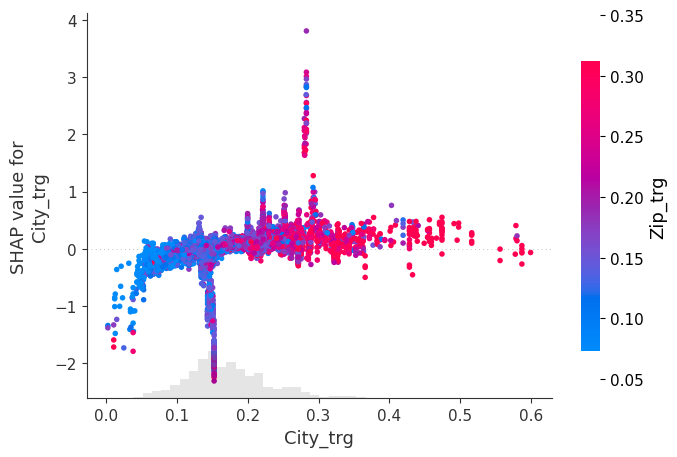

In [122]:
# Get interaction plot
shap.plots.scatter(shap_values[:, "City_trg"], color=shap_values[:,"Zip_trg"])

The above feature interaction plot displays the shapley values and interactions between the features `City` and `Zip`. As expected, cities whose target encoded value is lower tend to produce negative shapley values because based on the training data, the probability of default in those cities is lower, and as the target encoded value increases, the shapley values become more positive. Observing the interaction with `Zip` we notice that for the most part, if a city tends to produce smaller or more negative shapley contributions, the zipcodes within that city will also show similarly low shapley contributions and if a city tends to have high shapley contributions then the zipcodes within that city will also tend to have high shapley values. However, there are some exceptions to this rule as we can see some red points in the mostly blue area, indicating that within a city with low incidence of loan default there are still some zipcodes which have a much higher incidence of loan default. Similarly, we see some blue points in the mostly red area indicating that in certain cities where the loan default rate is high there are some smaller areas wherein the rate of default is predicted to be lower.


## Saving Artifacts

The artifacts will be saved to be used in the scoring function. Artifacts include the LightGBM model because it performed slightly better, categorical encoders, the calculated threshold, and several lists of columns that will be useful when scoring the model.

In [142]:
import pickle

# Saving artifacts 
artifacts_dict = {
        "cat_encoders": cat_encoders,
        "dollar_cols_to_convert": dollar_cols_to_convert,
        "num_to_cat_cols": num_to_cat_cols,
        "values_to_fill": values_to_fill,
        "target_encoder": target_encoder,
        "cols_to_target_encode": cols_to_target_encode,
        "cols_to_ohe": cols_to_ohe,
        "best_lgb": best_lgb,
        "best_threshold": best_threshold,
        "cols_to_train": cols_to_train,
    }


artifacts_dict_file = open("./artifacts/artifacts_dict_file.pkl", "wb")
pickle.dump(obj=artifacts_dict, file=artifacts_dict_file)
artifacts_dict_file.close() 

# Conclusion

By conducting an analysis of shapley summary plots and the shapley contributions on individual records for several correct and incorrect prediction scenarios we were able to identify some of the strong points and weak points of both models. 

Both the LightGBM and the H2O GBM model had difficulty using the target encoded `Bank`, `Zip`, and `FranchiseCode` features to make correct predictions. When the target encoded values were high the model tends to predict default, sometimes when the true lable indicates no default. However, the models are strong when correctly predicting no default if the value of the `SBAGrantRatio` feature is close to 1. 

The LightGBM model was ultimately chosen for scoring because with an AUC of 82.8% on the test data its performance was slightly higher than the H2O GBM model's performance.